# &#128992; Google Colab Setup and Installing Eureka!

**Important:** You will need to re-run these first two cells each time your runtime gets deleted.

&#128992; **This first cell will install Eureka!**

In [ ]:
# Install Eureka! (for now a dev branch, but in the future a stable branch)
!pip install eureka[jwst]@git+https://github.com/kevin218/Eureka.git@dev/tjb

# Make crds_cache folder
!mkdir crds_cache

  Cloning https://github.com/kevin218/Eureka.git (to revision dev/tjb) to /tmp/pip-install-wr2b6a_l/eureka_327d26244f3e429b96a8d5ed59552988
  Running command git clone --filter=blob:none --quiet https://github.com/kevin218/Eureka.git /tmp/pip-install-wr2b6a_l/eureka_327d26244f3e429b96a8d5ed59552988
  Running command git checkout -b dev/tjb --track origin/dev/tjb
  Switched to a new branch 'dev/tjb'
  Branch 'dev/tjb' set up to track remote branch 'dev/tjb' from 'origin'.
  Resolved https://github.com/kevin218/Eureka.git to commit eb14b480448b1e41093679ef72562b0575a898b7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/kevin218/Astraeus (to revision main) to /tmp/pip-install-wr2b6a_l/astraeus_a02b028162fb497f9d29bff14815148b
  Running command git clone --filter=blob:none --quiet https://github.com/kevin218/Astraeus /tmp/pip-install-wr2b6a_l/astraeus_a02b028162fb497f9d29bff1

In [ ]:
# You will be prompted to Permit this notebook to access your Google Drive files - Click on "Connect to Google Drive"
# You will then be prompted to Choose an account - click on your preferred Google account
# You will then confirm that Google Drive for desktop wants to access your Google Account - scroll to click "Allow"
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


&#128992; **After the cell above outputs "Mounted at /content/drive", click the "Runtime"->"Restart runtime" in the top menu bar, and then you can proceed with the cells below**

---
# Setting up the notebook

The first step is to setup the notebook and environment.

We'll first import Eureka! along with some other useful packages.

*(You can safely ignore the warning about starry and pymc3 - we didn't install them above to try and make the installation process a bit faster)*

In [ ]:
import eureka
import os
import numpy as np

Could not import starry and/or pymc3 related packages. Functionality may be limited.


Next, we need to choose a short, meaningful label (without spaces) that describes the data we're currently working on. For simplicity, we will just set `eventlabel = 'miri'`. This same event label should be used throughout all stages.

In [ ]:
eventlabel = 'miri'

---
# Visualizing the input Stage 2 files

To help you visualize the inputs into Eureka!'s Stage 3, we'll first visually examine the calints files you were provided.



```
# Import required packages
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Set the filename variable to point to one of the input files
# NOTE: If you run this code yourself, you'll have to adjust the foldername
#       based on your directory setup
drivedir = '/content/drive/MyDrive/'
foldername = 'SSW2023/MIRI/Stage2/'
filename = 'jw01366011001_04103_00003-seg007_mirimage_calints.fits'

# Read in the file
s2_file = fits.open(drivedir+foldername+filename)

# Let's visualize the first integration
integ1 = s2_file[1].data[0]

# Plotting the image
plt.figure(figsize=(3,8))
plt.imshow(integ1, cmap='bone', origin='lower', norm=colors.LogNorm(vmin=30, vmax=np.max(integ1)))
plt.xlabel('x-axis (pixels)')
plt.ylabel('y-axis (pixels)')
plt.colorbar(label='Flux (DN/s)')

# These lines will show some potentially reasonable ywindow values to use below
plt.axhline(140, color='red')
plt.axhline(405, color='red')

# These lines will show some potentially reasonable xwindow values to use below
plt.axvline(11, color='cyan')
plt.axvline(61, color='cyan')

plt.show()
```
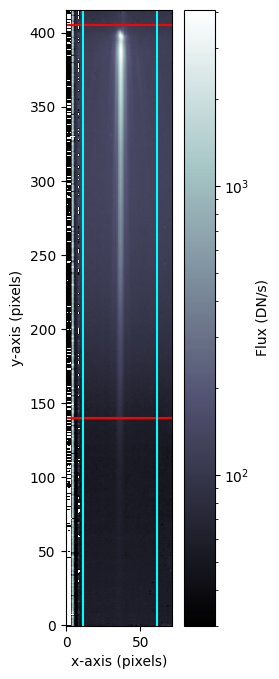



```
# Now let's look at the lightcurve of a couple pixels summed together (to reduce noise)
pixel_lightcurve = s2_file[1].data[:,140:393,32:40].sum(axis=(1,2))

# Plotting the data
plt.figure(figsize=(8,4))
plt.plot(pixel_lightcurve, '.', color='black')
plt.xlabel('Integration Number')
plt.ylabel('Flux (DN/s)')

plt.show()
```
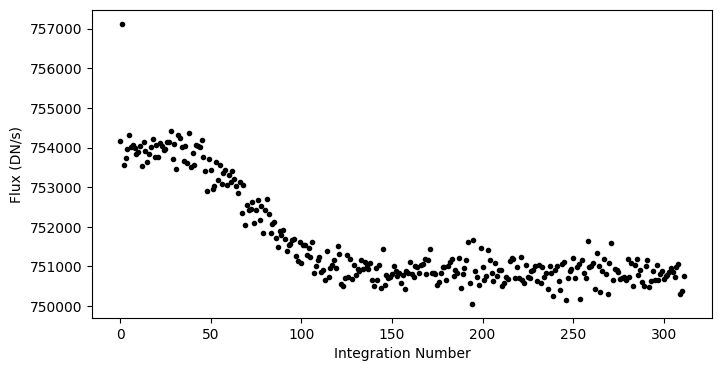

Excitingly, there is already a clear astrophysical signal in the uncalibrated data! I have only plotted the second of four files provided to you; the first and last segment provide critical out-of-eclipse baseline observations (measuring the star+planet light), the second segment includes the eclipse ingress (planet passing behind the star), and the third segment includes the eclipse egress (planet reappearing from behind the star). We'll now work on getting clean reliable spectroscopic lightcurves out of these input files using the Eureka! pipeline.

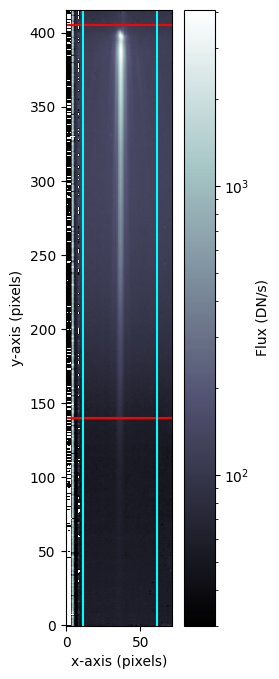

In [ ]:
# Import required packages
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Set the filename variable to point to one of the input files
# NOTE: If you run this code yourself, you'll have to adjust the foldername
#       based on your directory setup
drivedir = '/content/drive/MyDrive/'
foldername = 'SSW2023/MIRI/Stage2/'
filename = 'jw01366011001_04103_00003-seg007_mirimage_calints.fits'

# Read in the file
s2_file = fits.open(drivedir+foldername+filename)

# Let's visualize the first integration
integ1 = s2_file[1].data[0]

# Plotting the image
plt.figure(figsize=(3,8))
plt.imshow(integ1, cmap='bone', origin='lower', norm=colors.LogNorm(vmin=30, vmax=np.max(integ1)))
plt.xlabel('x-axis (pixels)')
plt.ylabel('y-axis (pixels)')
plt.colorbar(label='Flux (DN/s)')

# These lines will show some potentially reasonable ywindow values to use below
plt.axhline(140, color='red')
plt.axhline(405, color='red')

# These lines will show some potentially reasonable xwindow values to use below
plt.axvline(11, color='cyan')
plt.axvline(61, color='cyan')

plt.show()

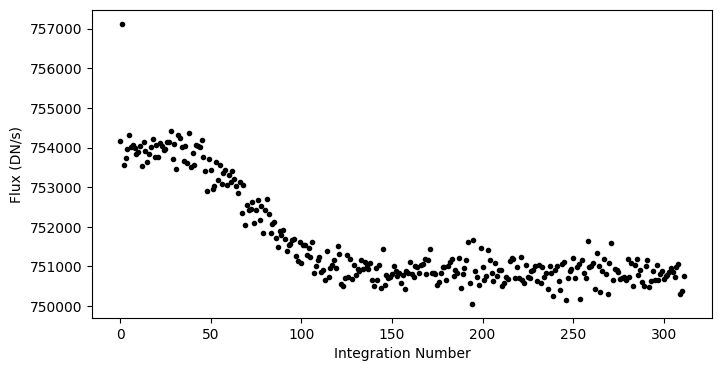

In [ ]:
# Now let's look at the lightcurve of a couple pixels summed together (to reduce noise)
pixel_lightcurve = s2_file[1].data[:,140:393,32:40].sum(axis=(1,2))

# Plotting the data
plt.figure(figsize=(8,4))
plt.plot(pixel_lightcurve, '.', color='black')
plt.xlabel('Integration Number')
plt.ylabel('Flux (DN/s)')

plt.show()


---
# Eureka!'s Stage 3

### Setting the Stage 3 "Eureka! Control File" (ECF)

**This determines what will happen during Stage 3**

To begin, please first copy below the contents of the ECF template for MIRI/LRS from the `S3_miri_lrs_template.ecf` file in the ECF demos folder on [GitHub](https://github.com/kevin218/Eureka/tree/main/demos/JWST).

The most important parameters and their recommended settings are described below, but more context can be found on the [Eureka! documentation website](https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-3).

1.   Set the number of CPU threads to `1` (you can increase this to ~2x your CPU core count if you're not using Google Colab for faster runs).
2.   Add a new parameter called `gain` and set its value to `3.1` because the current CRDS reference file assumes it is 5.5 which is known to be wrong. To add a new parameter, start by making a new line anywhere in the ECF, add the name of the new parameter, add one or many spaces after the name, and then add the value.
3.   Set the `ywindow` so that it captures the bright region containing the star. As described above, a reasonable setting would be `[140, 405]`.
4.   Set the `xwindow` so that it excludes obviously bad columns (e.g. columns 0–10). Because there is a known linear slope to the MIRI/LRS background, it is important that you either (a) ensure that there are an equal number of background pixels to the left and right of the source and set bg_deg equal to 0 or (b) use any reasonable xwindow values set bg_deg=1 (easier to do, but comes at a penalty of higher noise). A reasonable setting would be `[11, 61]` with `bg_deg` set to `0`.
5.   Choose the `gaussian` centroiding method to be able to measure the spatial position and PSF-width of the star.
6.   Set `record_ypos` to `True` to record the position and PSF-width of the star on the detector for all frames (will give us useful values to decorrelate against in Session 2).
7.   Set `dqmask` to `True` to mask bad pixels (e.g. cosmic ray hits) identified by the jwst pipeline and marked in the DQ array of the input calints files.
8.   Set the `bg_hw` (background exclusion area half-width) to something large enough to not include significant starlight (something between `8` and `15` should do).
9.   Set the `bg_thresh` (background area outlier threshold) values to `[5,5]` to do two iterations of 5-sigma clipping along the time axis to remove artifacts like cosmic rays.
10.  Set `bg_deg` according to point #4 above.
11.  Set `p3thresh` to `5` to sigma-clip 5-sigma outliers along the spatial direction. This will help to remove any remaining starlight left.
12.  Set `spec_hw` (spectral aperture half-width) to something large enough to capture much of the starlight (something between `4` and `8` should do).
13.  Set `fittype` to `meddata` to use the median frame (median computed along the time axis) as the profile for the optimal extraction method.
14.  Set `windowlen` to `1` so that no spectral smoothing is applied to the optimal extraction profile (at least for now - you can experiment with smoothing later if you want).
15.  Set `median_thresh` to `5` to clip 5-sigma outliers along the spectral-axis when computing the median frame.
16.  You can safely ignore `prof_deg` (only used if fittype=poly) and `p5thresh` (only used when `fittype` is `smooth`, `poly`, or `gauss`)
17.  Set `p7thresh` to `10` to sigma-clip 10-sigma outlier pixels compared to the optimal profile.
18.  Set `isplots_S3` to `4` to get lots of useful diagnostic figures (increase this to 5 if you need more plots to investigate problems).
19.  Set `nplots` to `5` to make repetitive figures only for the first 5 integrations (you can increase this as needed if you want more figures for troubleshooting)
20.  Set `hide_plots` to `False` so that the figures pop up in this notebook as they're made (set to `True` if you're not running the code in a notebook, otherwise you'll have a lot of windows popping up).
21.  Set `verbose` to `True` so you get lots of useful information printed out.
22.  &#128992; Set `topdir` to the folder containing your Stage 2 folder. This should start with /content/drive/MyDrive/ (this is where your Google Drive files get mounted) and then specify the folder structure you setup. For example, if your Stage2 files on Google Drive are in SSW2023→MIRI→Stage2, then set `topdir` to `/content/drive/MyDrive/SSW2023/MIRI`.  &#128309; If you are using the Jupyter notebook, set `topdir` to the full parent directory of Stage2.

In [ ]:
s3_ecf_contents = f"""
# Eureka! Control File for Stage 3: Data Reduction

# Stage 3 Documentation: https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-3

ncpu            1           # Number of CPUs
gain            3.1
nfiles          1           # The number of data files to analyze simultaneously
max_memory      0.5         # The maximum fraction of memory you want utilized by read-in frames (this will reduce nfiles if need be)
suffix          calints     # Data file suffix

convert_to_e    True        # Whether or not a conversion to electrons should be performed (can set to False to compute flux-calibrated spectra/photometry)

# Subarray region of interest
ywindow         [140, 393]  # Vertical axis as seen in DS9
xwindow         [11, 61]    # Horizontal axis as seen in DS9
src_pos_type    gaussian    # Determine source position when not given in header (Options: header, gaussian, weighted, max, or hst)
record_ypos     True        # Option to record the y position and width for each integration (only records if src_pos_type is gaussian)
dqmask          True        # Mask pixels with an odd entry in the DQ array

# Outlier rejection along time axis
ff_outlier      False       # Set False to use only background region (recommended for deep transits)
                            # Set True to use full frame (works well for shallow transits/eclipses)
bg_thresh       [5,5]       # Double-iteration X-sigma threshold for outlier rejection along time axis

# Background parameters
bg_hw           8         # Half-width of exclusion region for BG subtraction (relative to source position)
bg_deg          0           # Polynomial order for column-by-column background subtraction, -1 for median of entire frame
p3thresh        5           # X-sigma threshold for outlier rejection during background subtraction

# Spectral extraction parameters
spec_hw         8           # Half-width of aperture region for spectral extraction (relative to source position)
fittype         meddata     # Method for constructing spatial profile (Options: smooth, meddata, poly, gauss, wavelet, or wavelet2D)
median_thresh   5           # Sigma threshold when flagging outliers in median frame, when fittype=meddata and window_len > 1
window_len      1           # Smoothing window length, for median frame or when fittype = smooth or meddata (when computing median frame). Can set to 1 for no smoothing when computing median frame for fittype=meddata.
prof_deg        3           # Polynomial degree, when fittype = poly
p5thresh        10          # X-sigma threshold for outlier rejection while constructing spatial profile
p7thresh        10          # X-sigma threshold for outlier rejection during optimal spectral extraction

# Diagnostics
isplots_S3      4           # Generate few (1), some (3), or many (5) figures (Options: 1 - 5)
nplots          5           # How many of each type of figure do you want to make per file?
vmin            0.97        # Sets the vmin of the color bar for Figure 3101.
vmax            1.03        # Sets the vmax of the color bar for Figure 3101.
time_axis       'y'         # Determines whether the time axis in Figure 3101 is along the y-axis ('y') or the x-axis ('x')
testing_S3      False       # Boolean, set True to only use last file and generate select figures
hide_plots      False       # If True, plots will automatically be closed rather than popping up
save_output     True        # Save outputs for use in S4
verbose         True        # If True, more details will be printed about steps

# Project directory
topdir          /content/drive/MyDrive/SSW2023/MIRI

# Directories relative to topdir
inputdir        Stage2      # The folder containing the outputs from Eureka!'s S2 or JWST's S2 pipeline (will be overwritten if calling S2 and S3 sequentially)
outputdir       Stage3

# Fill this text block with the contents of the S3 MIRI/LRS ECF template from https://github.com/kevin218/Eureka/tree/main/demos/JWST
# and then adjust the values as described above

"""

# This will save the ECF as a file that the next cell can read-in
with open(f'./S3_{eventlabel}.ecf', 'w') as f:
    f.write(s3_ecf_contents)

### Running Eureka!'s Stage 3

The following cell will run Eureka!'s Stage 3 using the settings you defined above. Note that your ECF will be copied to your output folder, making it easy to remember how you produced those outputs hours, days, or years after you reduced the data.

This stage of Eureka! will take ~3 minutes to complete on Google Colab for these particular data.

"/content/drive/MyDrive/SSW2023/MIRI/Stage2/"
Assuming this S2 data was produced by the JWST pipeline instead.

Starting Stage 3 Reduction

Input directory: /content/drive/MyDrive/SSW2023/MIRI/Stage2/
Output directory: /content/drive/MyDrive/SSW2023/MIRI/Stage3/S3_2023-07-28_miri_run2/ap8_bg8/
Using ap=8, bg=8
Copying S3 control file

Found 5 data file(s) ending in calints.fits
Starting file 1 of 5
  Masking NaNs/infs in data arrays...
  Locating source position...


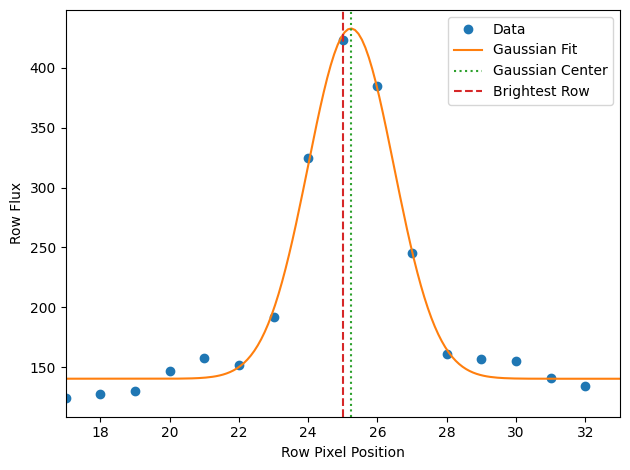

    Source position on detector is row 25.
  Using provided gain=3.1 to convert units to electrons...
  Converting from data numbers per second (DN/s) to electrons...
  Computing clean median frame...


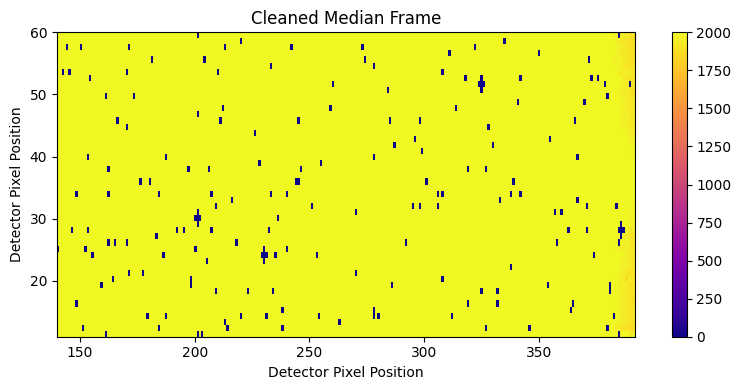

  Performing background outlier rejection...
  Performing CxC background subtraction...


100%|██████████| 312/312 [00:24<00:00, 12.92it/s]


  Creating figures for background subtraction...


  0%|          | 0/5 [00:00<?, ?it/s]

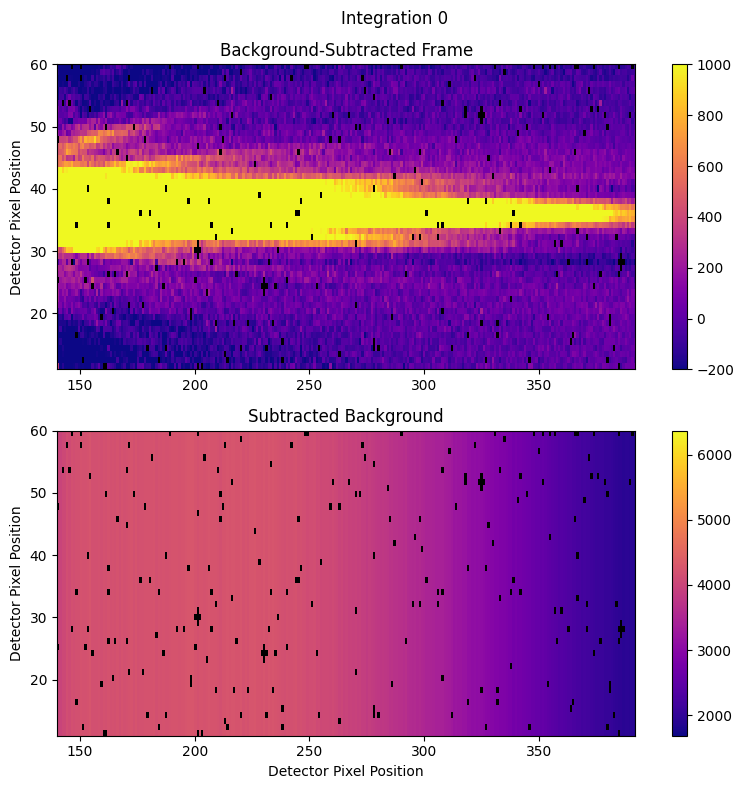

 20%|██        | 1/5 [00:01<00:06,  1.73s/it]

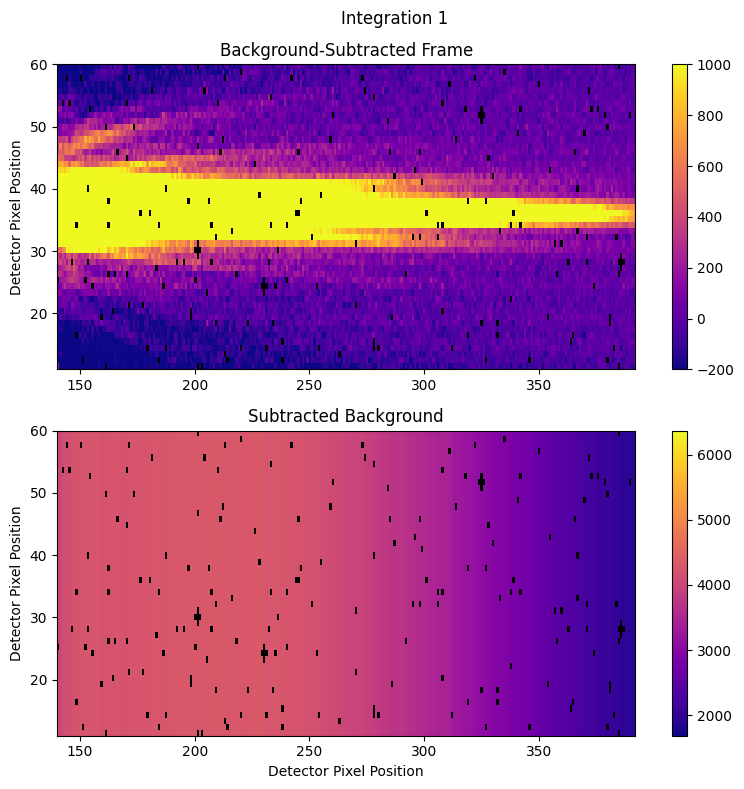

 40%|████      | 2/5 [00:03<00:05,  1.90s/it]

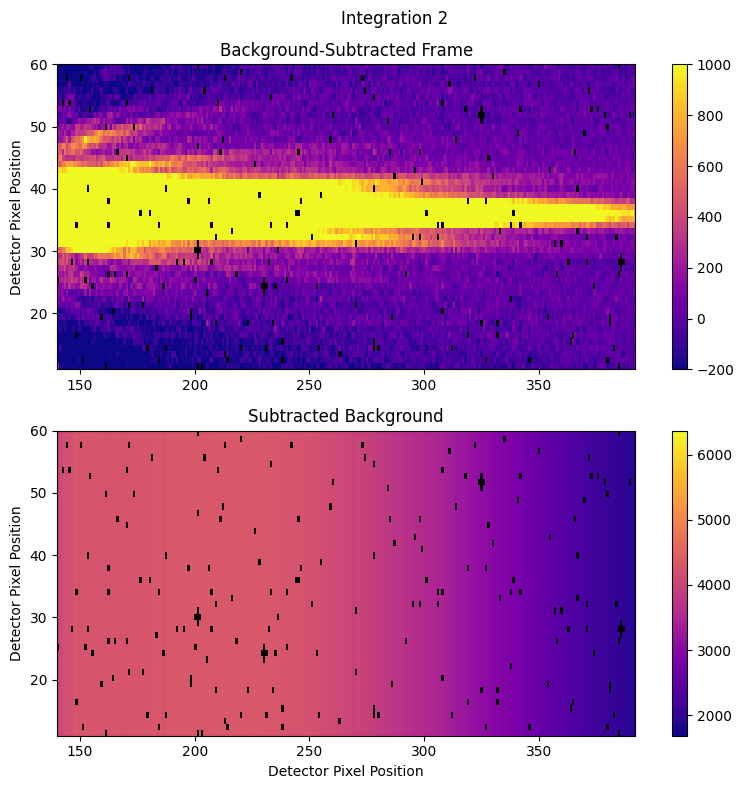

 60%|██████    | 3/5 [00:05<00:03,  1.91s/it]

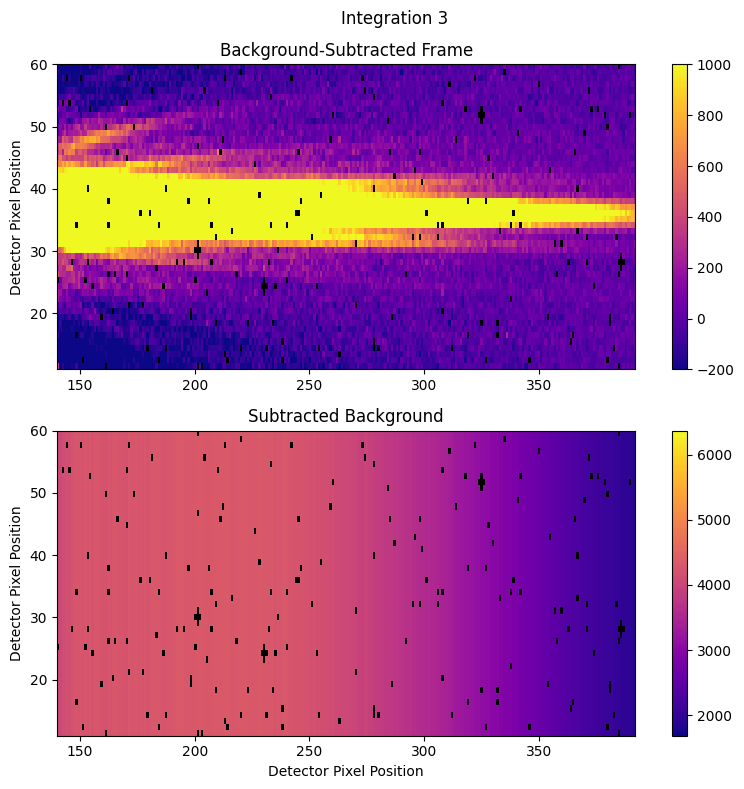

 80%|████████  | 4/5 [00:09<00:02,  2.70s/it]

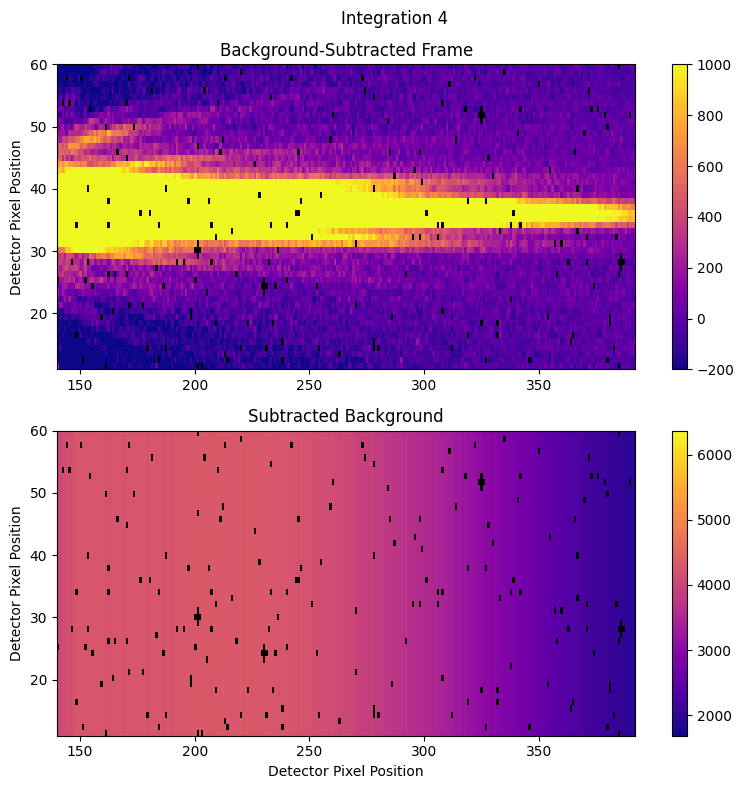

100%|██████████| 5/5 [00:12<00:00,  2.42s/it]

  Recording y position and width for all integrations...



100%|██████████| 312/312 [00:01<00:00, 184.02it/s]


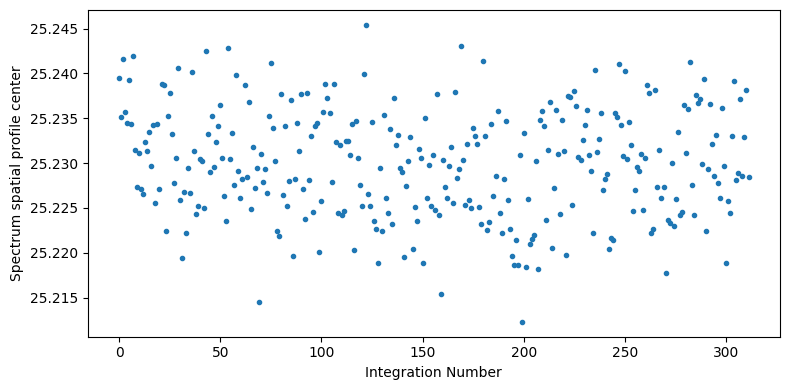

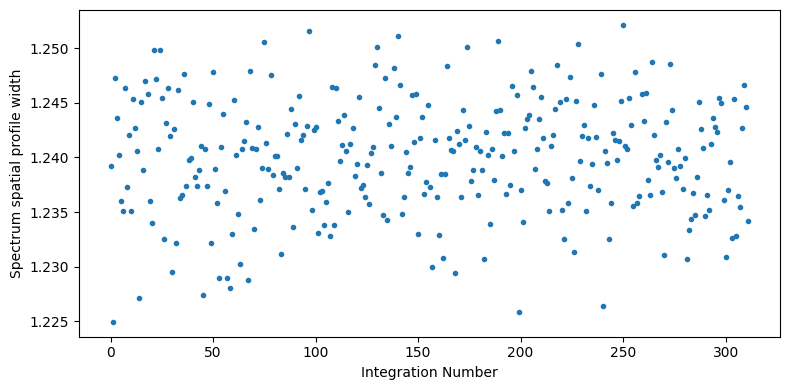

  Extracting aperture region...
  Performing optimal spectral extraction...


  0%|          | 0/312 [00:00<?, ?it/s]

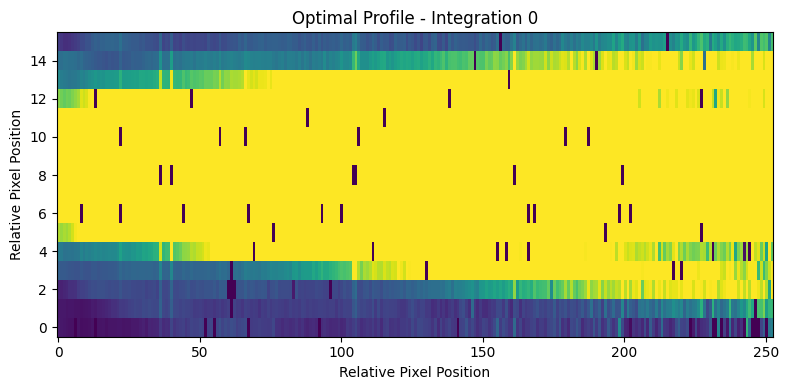

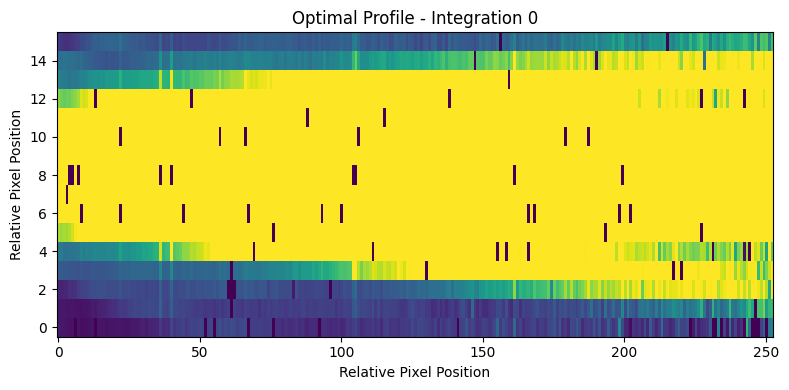

  0%|          | 1/312 [00:01<09:09,  1.77s/it]

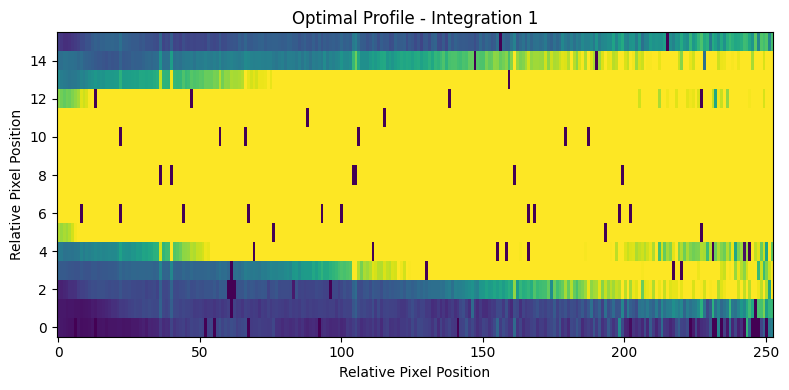

  1%|          | 2/312 [00:02<06:29,  1.26s/it]

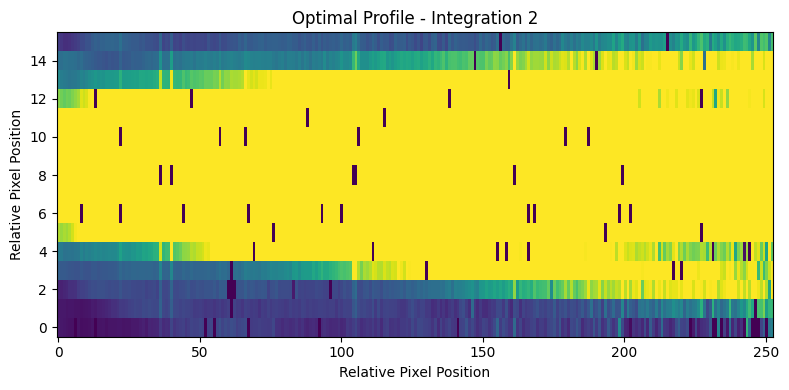

  1%|          | 3/312 [00:03<05:38,  1.09s/it]

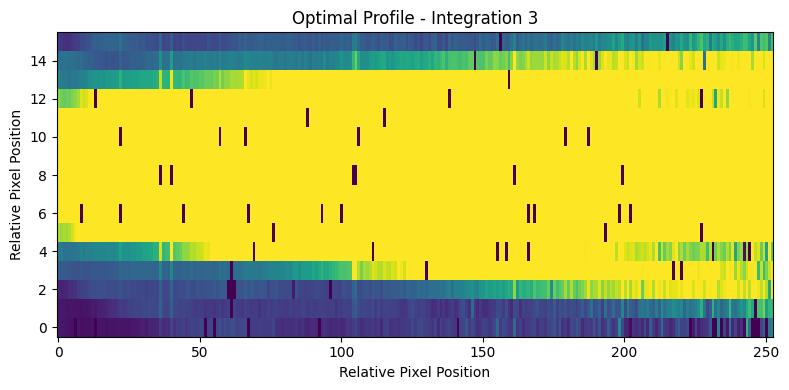

  1%|▏         | 4/312 [00:04<05:11,  1.01s/it]

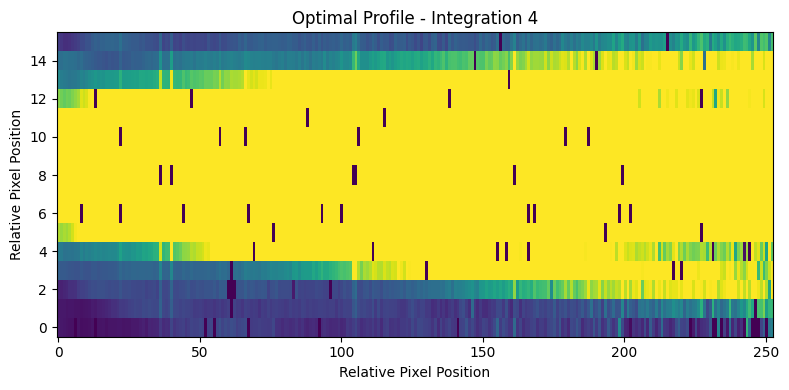

100%|██████████| 312/312 [00:06<00:00, 48.52it/s] 

  Creating figures for optimal spectral extraction



  0%|          | 0/5 [00:00<?, ?it/s]

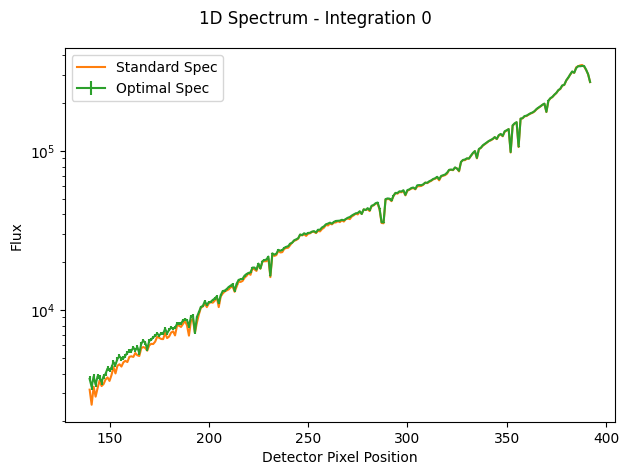

 20%|██        | 1/5 [00:01<00:04,  1.11s/it]

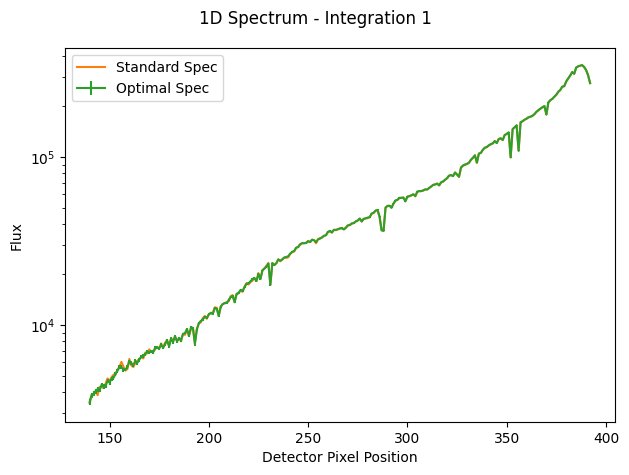

 40%|████      | 2/5 [00:02<00:03,  1.09s/it]

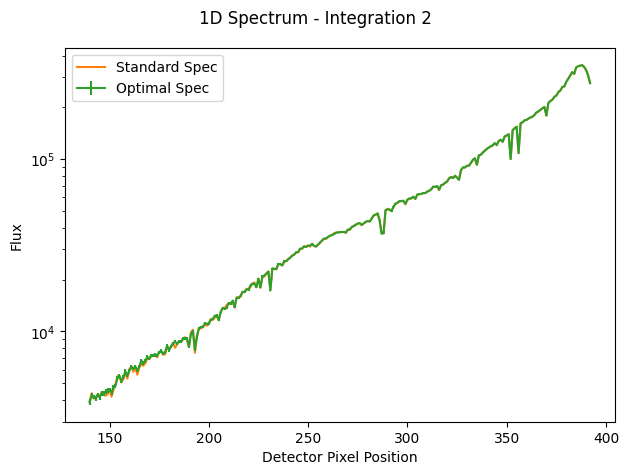

 60%|██████    | 3/5 [00:03<00:02,  1.34s/it]

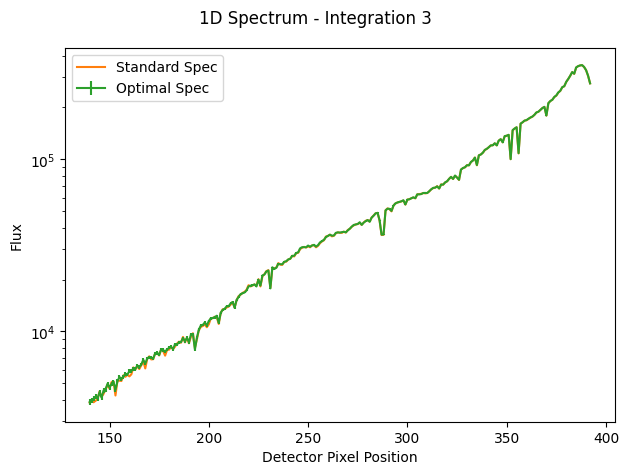

 80%|████████  | 4/5 [00:05<00:01,  1.45s/it]

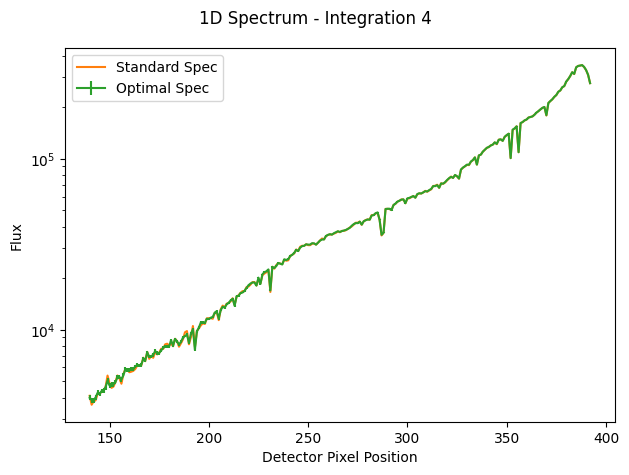

100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


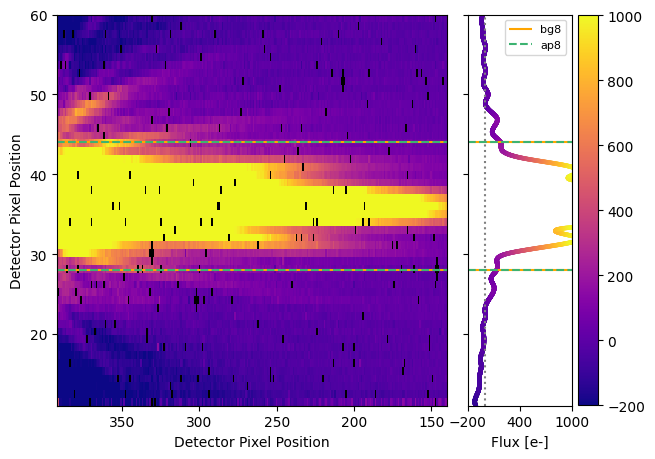

Finished writing to /content/drive/MyDrive/SSW2023/MIRI/Stage3/S3_2023-07-28_miri_run2/ap8_bg8/S3_miri_ap8_bg8_FluxData_seg0000.h5
Starting file 2 of 5
  Masking NaNs/infs in data arrays...
  Locating source position...


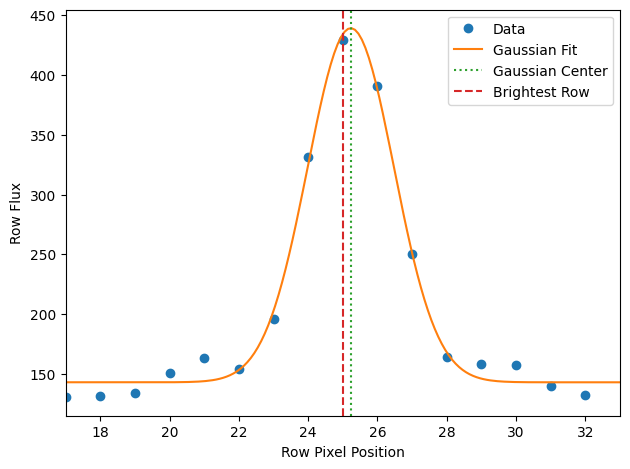

    Source position on detector is row 25.
  Using provided gain=3.1 to convert units to electrons...
  Converting from data numbers per second (DN/s) to electrons...
  Computing clean median frame...


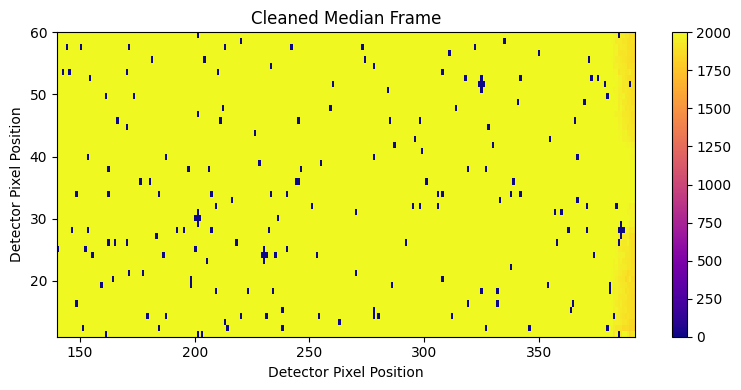

  Performing background outlier rejection...
  Performing CxC background subtraction...


100%|██████████| 312/312 [00:25<00:00, 12.40it/s]


  Creating figures for background subtraction...


  0%|          | 0/5 [00:00<?, ?it/s]

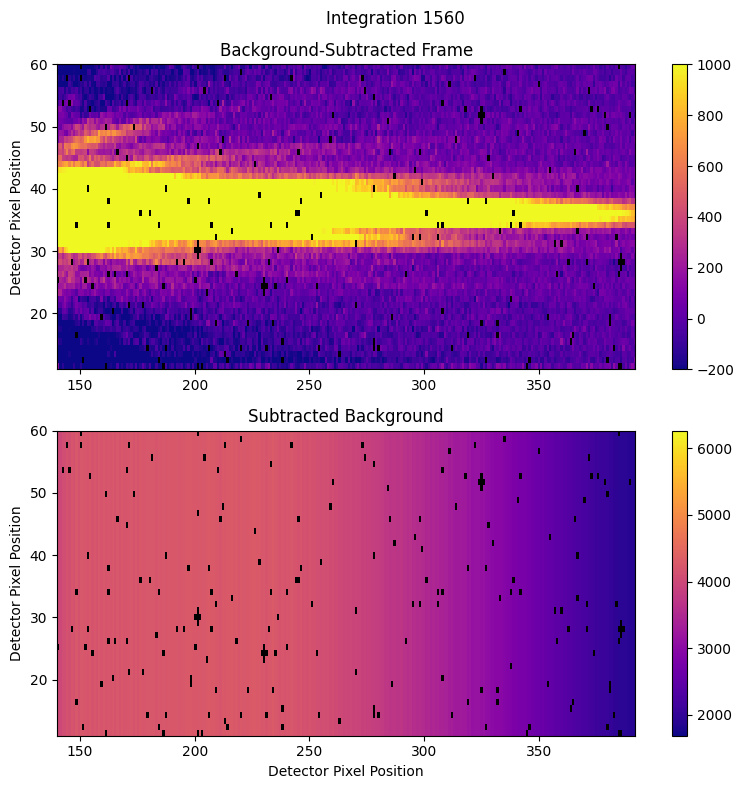

 20%|██        | 1/5 [00:02<00:10,  2.61s/it]

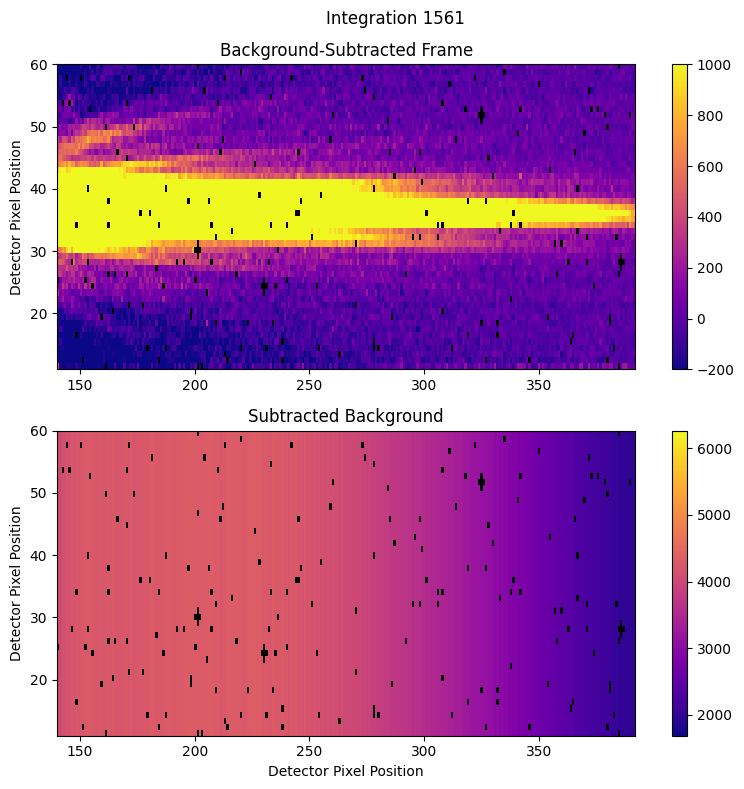

 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

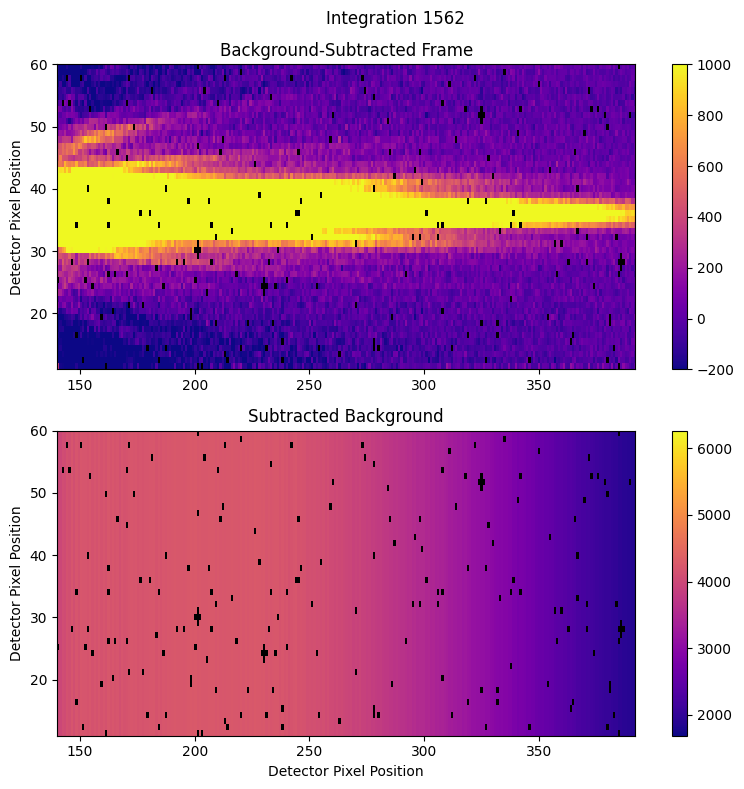

 60%|██████    | 3/5 [00:06<00:04,  2.13s/it]

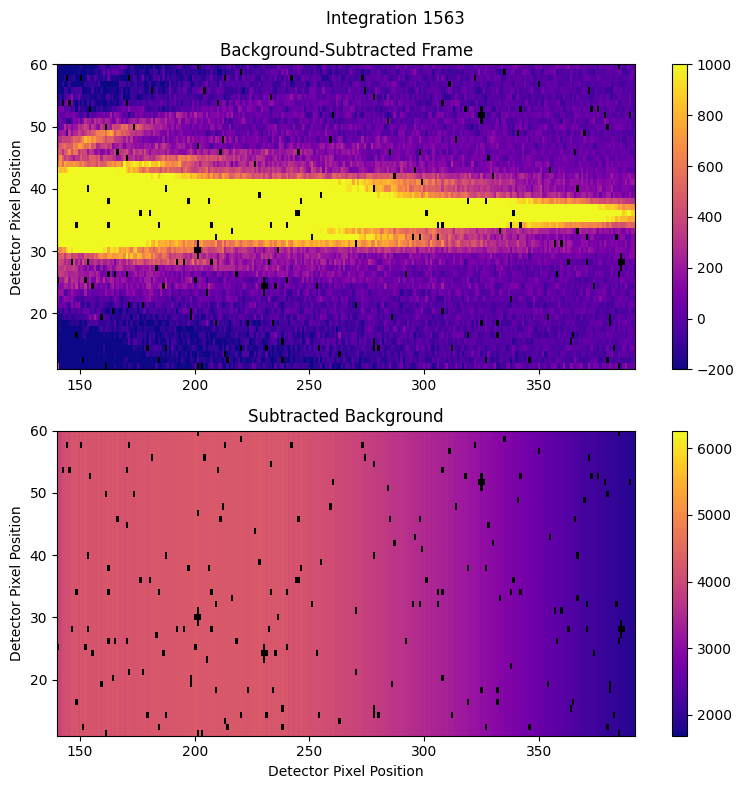

 80%|████████  | 4/5 [00:08<00:01,  1.95s/it]

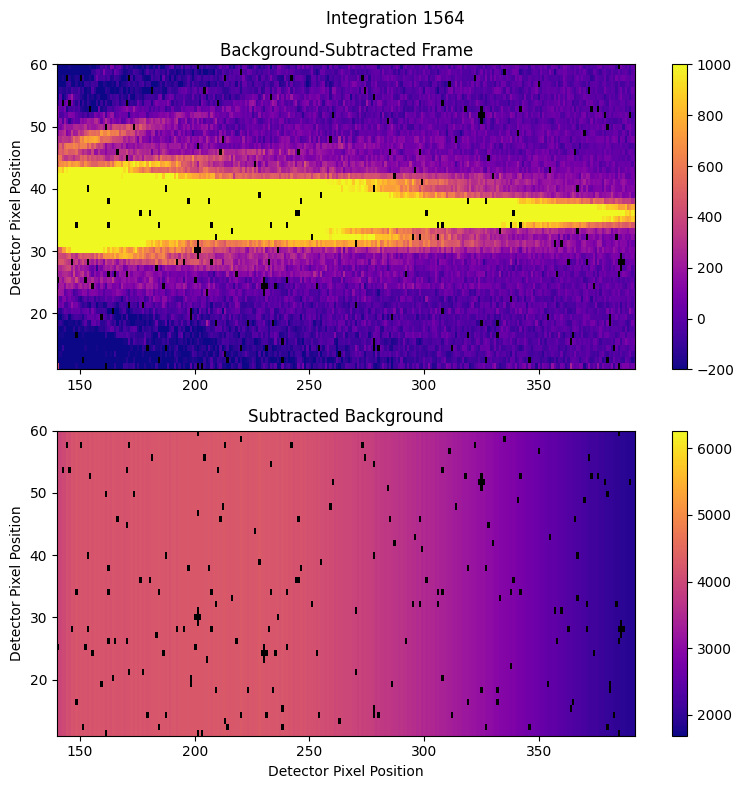

100%|██████████| 5/5 [00:10<00:00,  2.02s/it]

  Recording y position and width for all integrations...



100%|██████████| 312/312 [00:01<00:00, 255.41it/s]


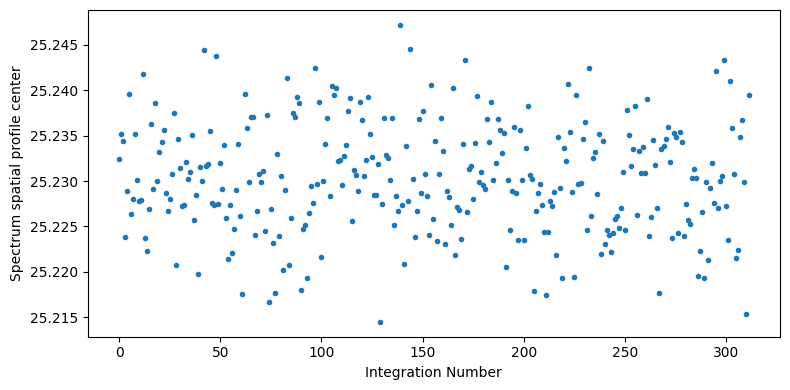

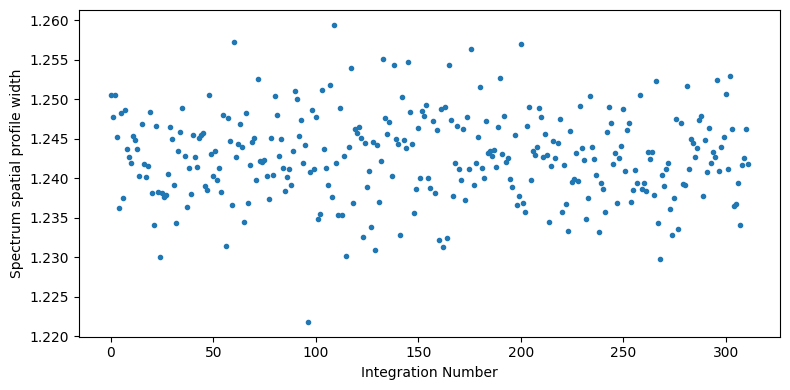

  Extracting aperture region...
  Performing optimal spectral extraction...


  0%|          | 0/312 [00:00<?, ?it/s]

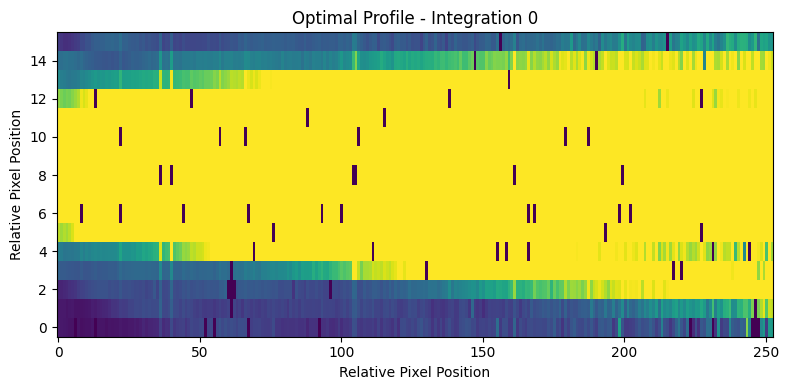

  0%|          | 1/312 [00:00<04:42,  1.10it/s]

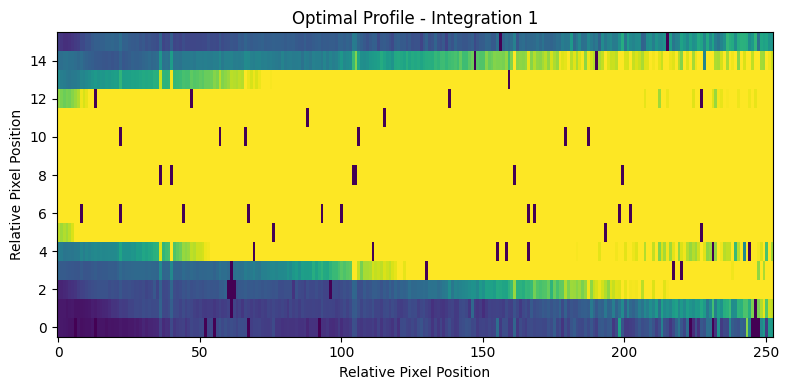

  1%|          | 2/312 [00:01<04:43,  1.09it/s]

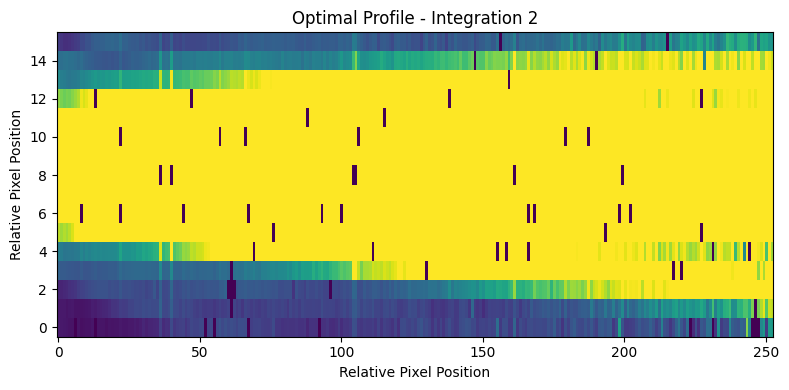

  1%|          | 3/312 [00:03<05:31,  1.07s/it]

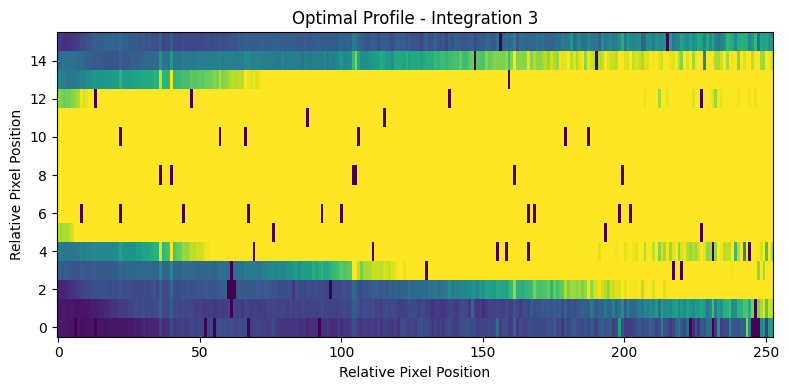

  1%|▏         | 4/312 [00:04<06:04,  1.18s/it]

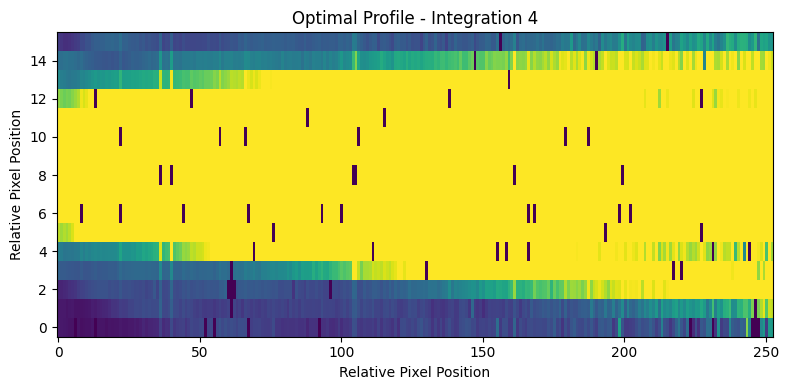

100%|██████████| 312/312 [00:07<00:00, 41.75it/s] 

  Creating figures for optimal spectral extraction



  0%|          | 0/5 [00:00<?, ?it/s]

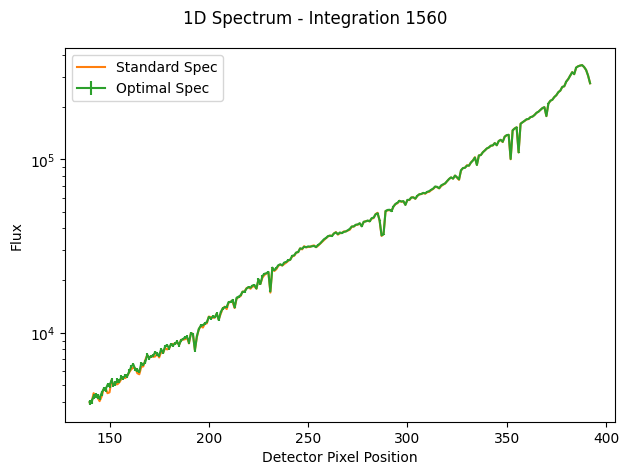

 20%|██        | 1/5 [00:02<00:08,  2.07s/it]

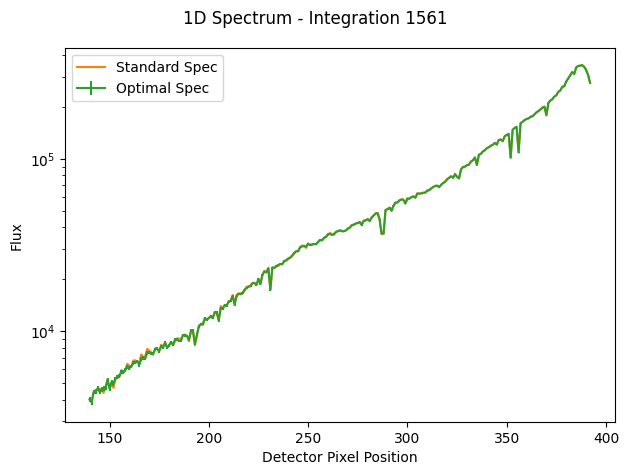

 40%|████      | 2/5 [00:03<00:05,  1.82s/it]

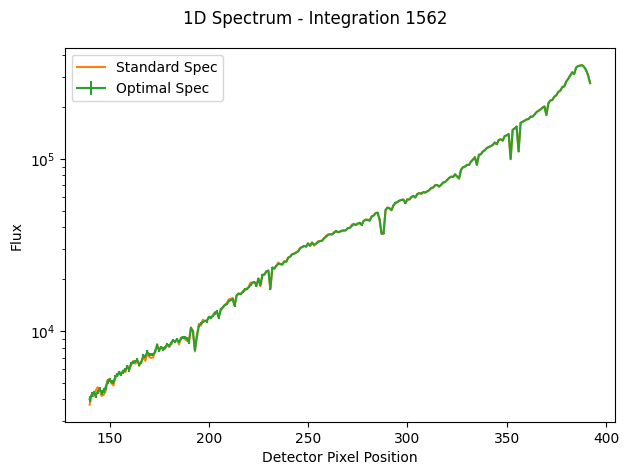

 60%|██████    | 3/5 [00:04<00:02,  1.50s/it]

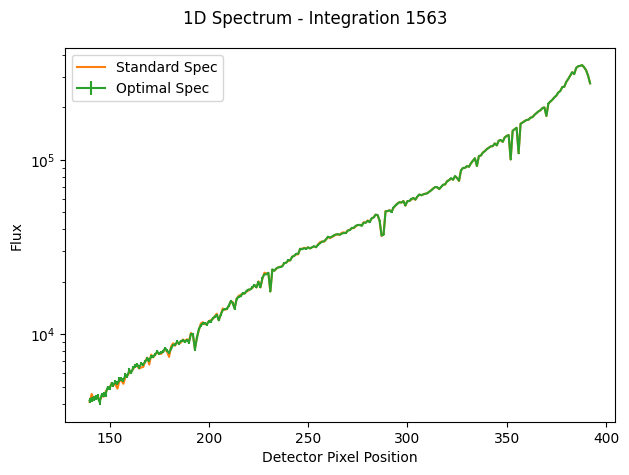

 80%|████████  | 4/5 [00:05<00:01,  1.34s/it]

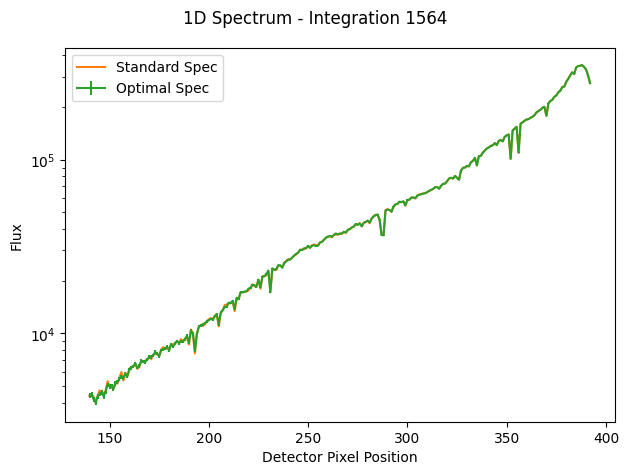

100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


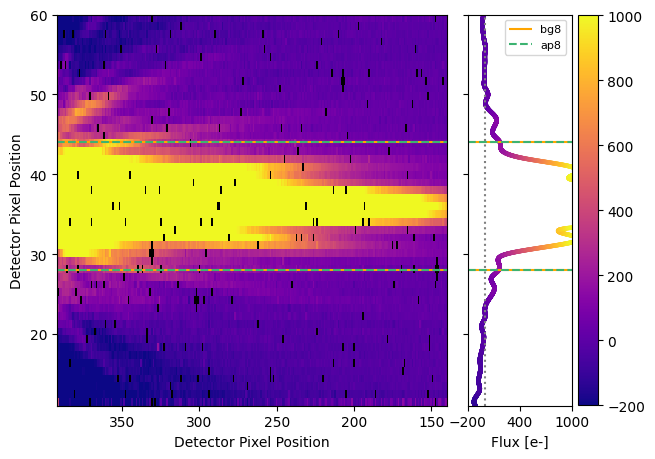

Finished writing to /content/drive/MyDrive/SSW2023/MIRI/Stage3/S3_2023-07-28_miri_run2/ap8_bg8/S3_miri_ap8_bg8_FluxData_seg0001.h5
Starting file 3 of 5
  Masking NaNs/infs in data arrays...
  Locating source position...


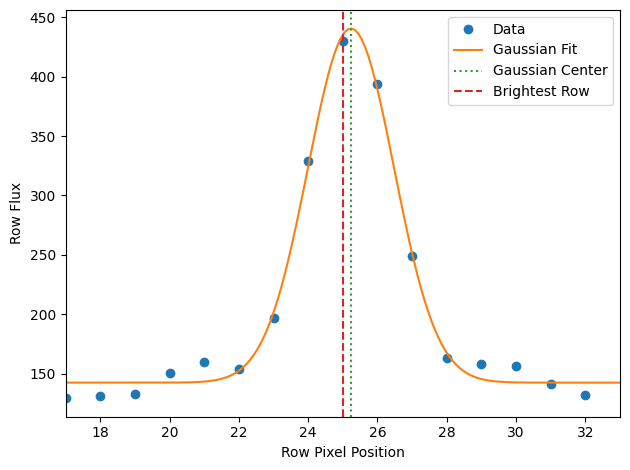

    Source position on detector is row 25.
  Using provided gain=3.1 to convert units to electrons...
  Converting from data numbers per second (DN/s) to electrons...
  Computing clean median frame...


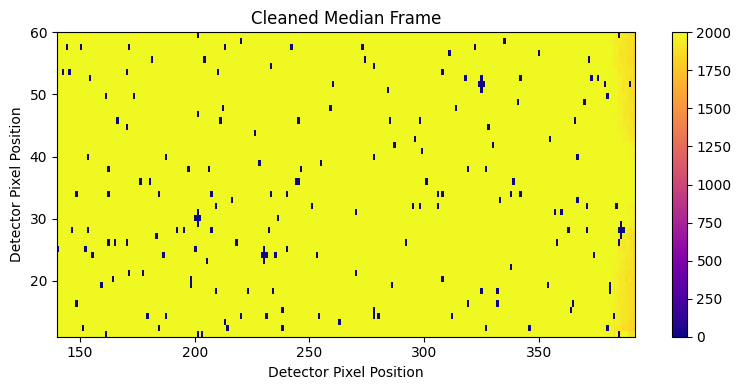

  Performing background outlier rejection...
  Performing CxC background subtraction...


100%|██████████| 312/312 [00:26<00:00, 11.60it/s]

  Creating figures for background subtraction...



  0%|          | 0/5 [00:00<?, ?it/s]

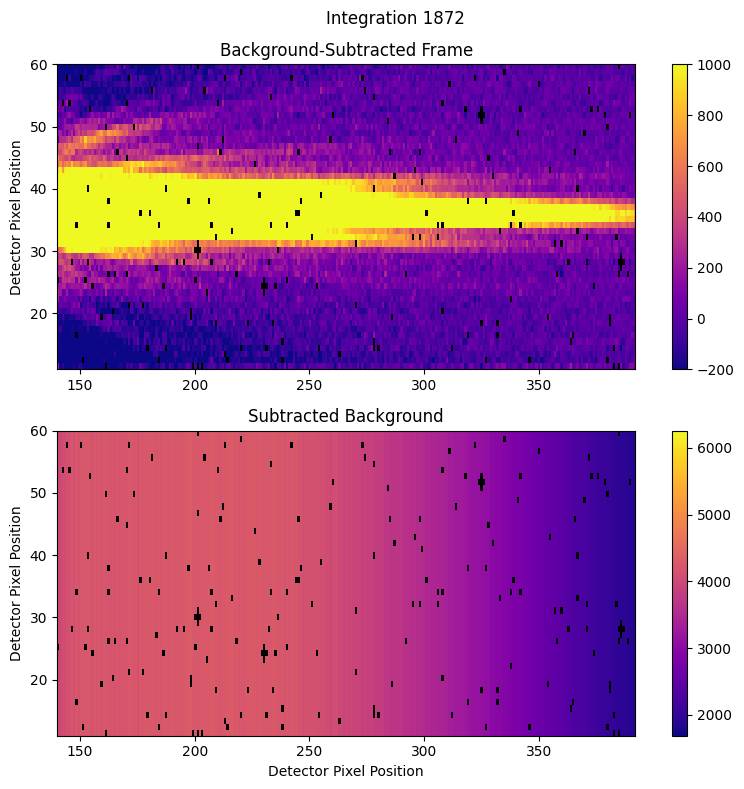

 20%|██        | 1/5 [00:02<00:09,  2.49s/it]

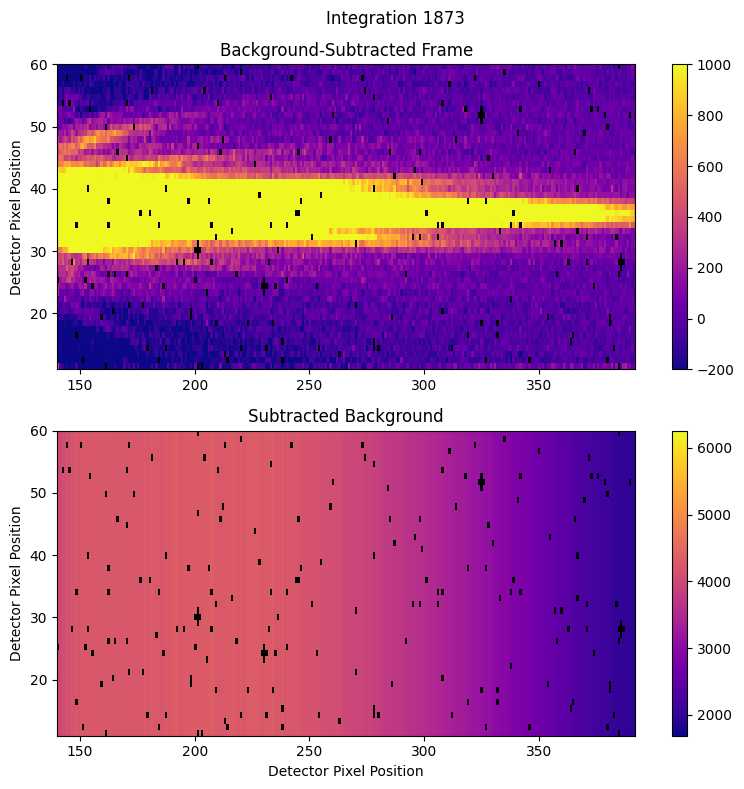

 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

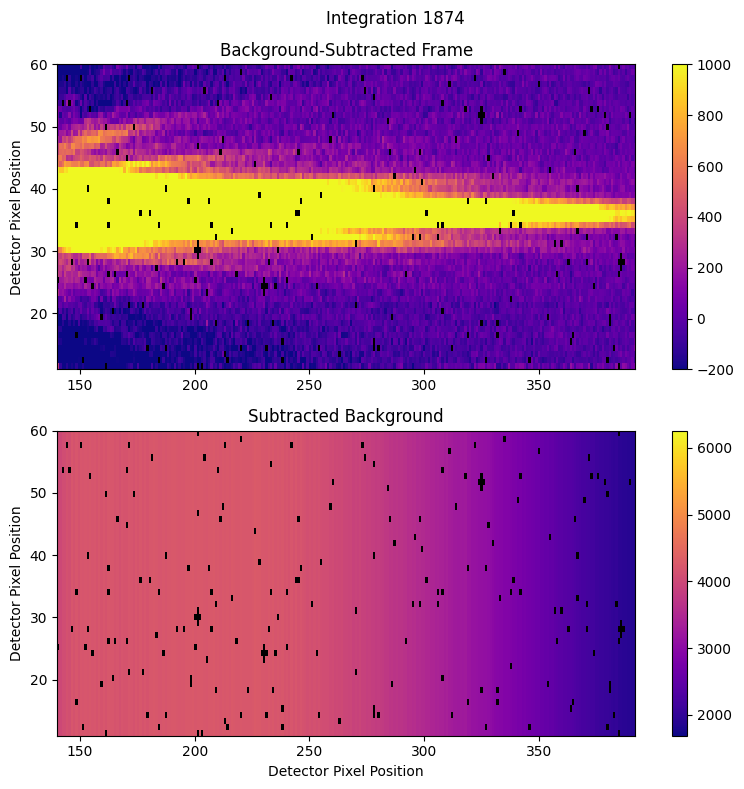

 60%|██████    | 3/5 [00:07<00:04,  2.30s/it]

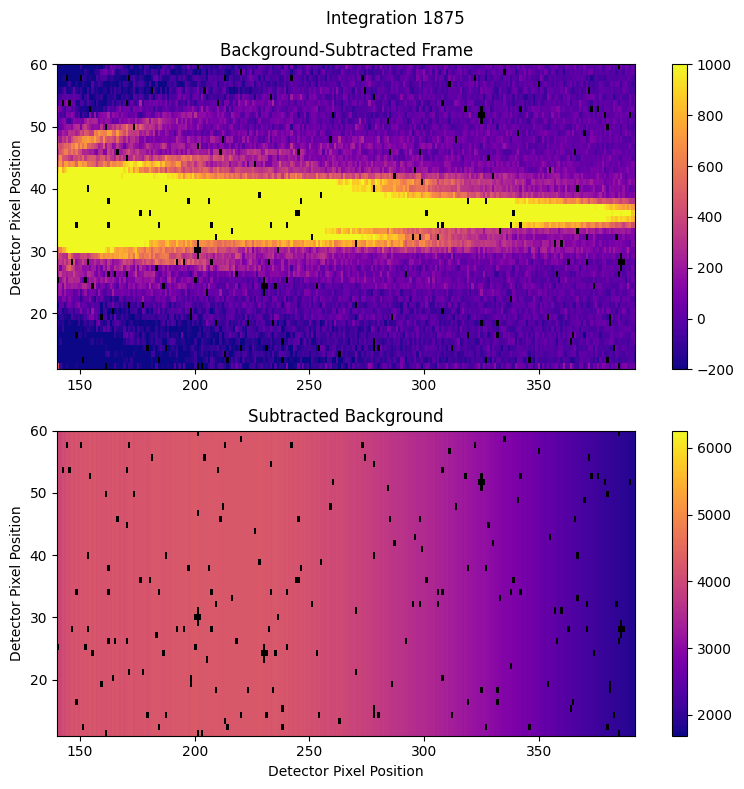

 80%|████████  | 4/5 [00:08<00:02,  2.05s/it]

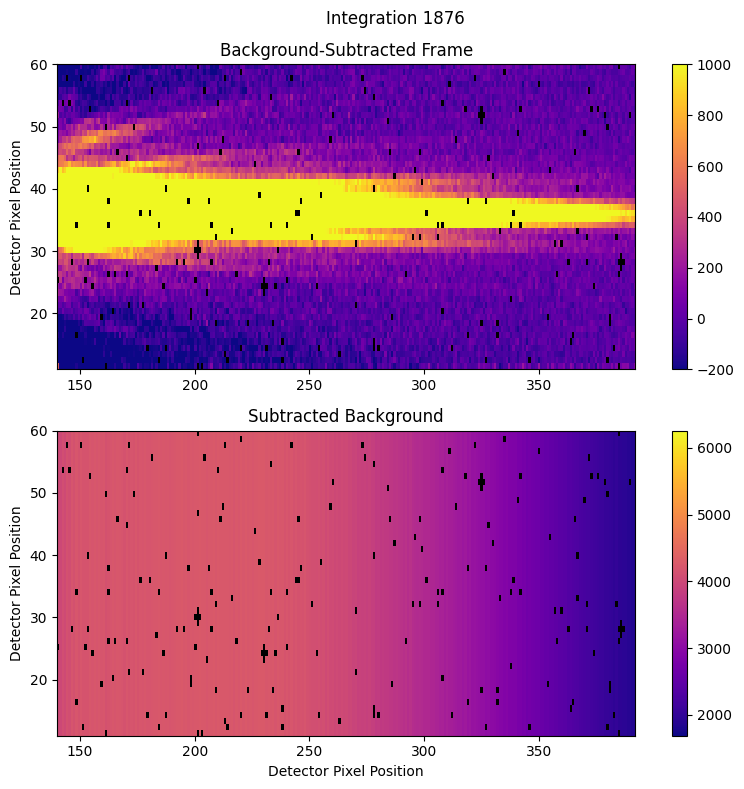

100%|██████████| 5/5 [00:10<00:00,  2.15s/it]

  Recording y position and width for all integrations...



100%|██████████| 312/312 [00:01<00:00, 233.23it/s]


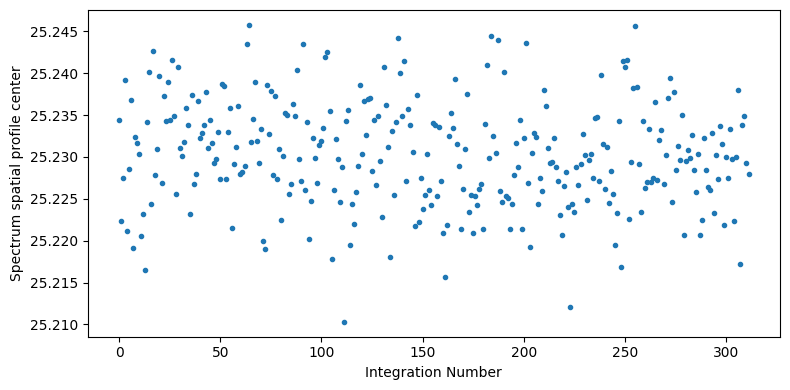

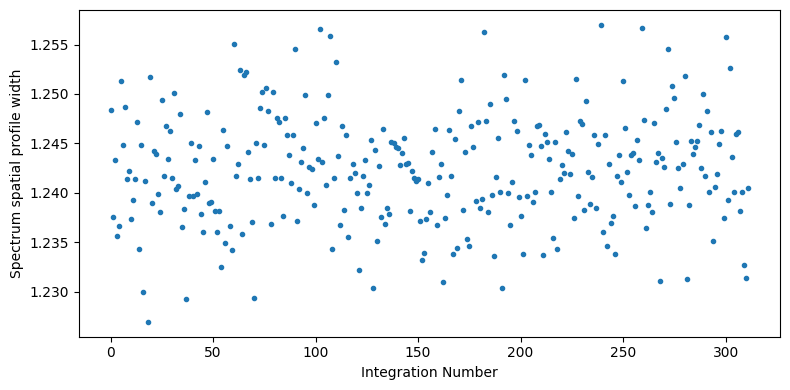

  Extracting aperture region...
  Performing optimal spectral extraction...


  0%|          | 0/312 [00:00<?, ?it/s]

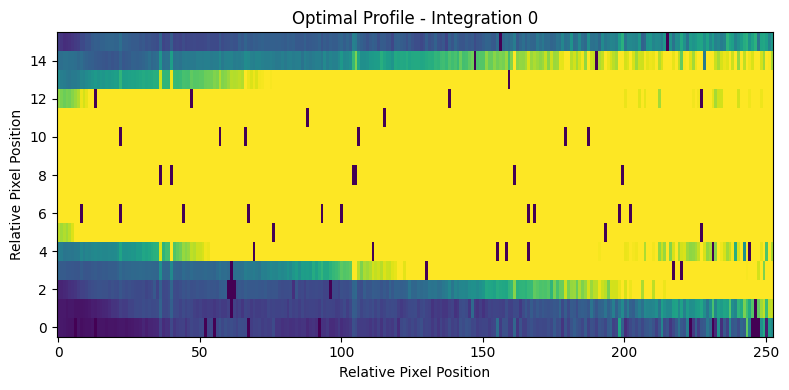

  0%|          | 1/312 [00:00<04:41,  1.11it/s]

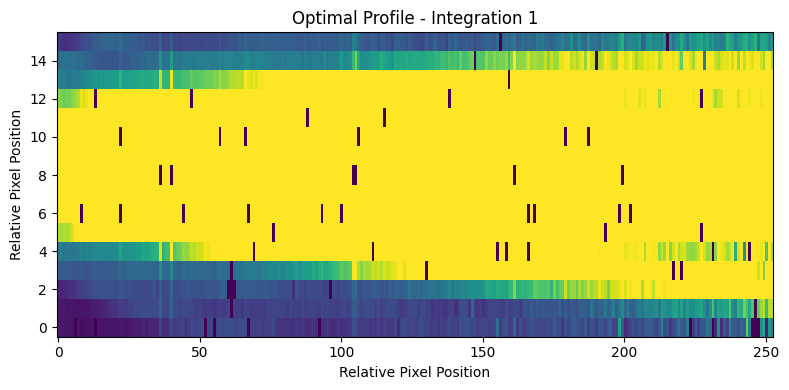

  1%|          | 2/312 [00:01<04:46,  1.08it/s]

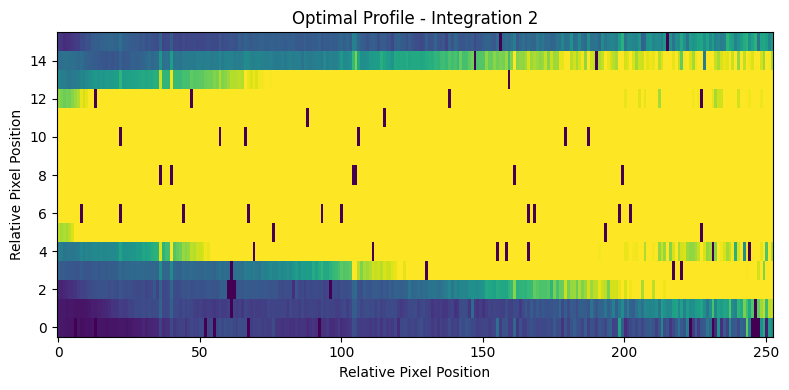

  1%|          | 3/312 [00:03<05:24,  1.05s/it]

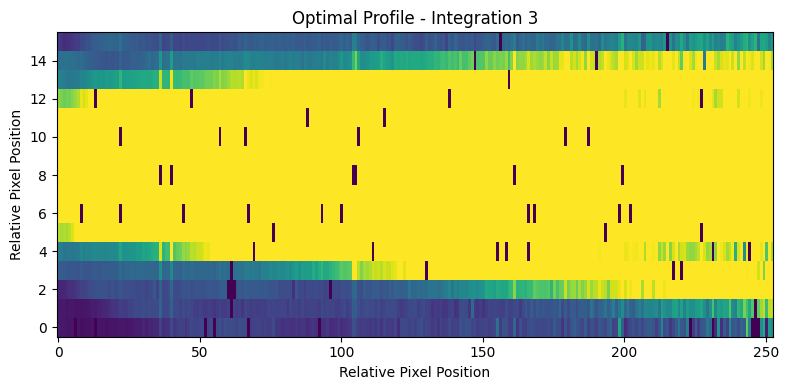

  1%|▏         | 4/312 [00:04<05:53,  1.15s/it]

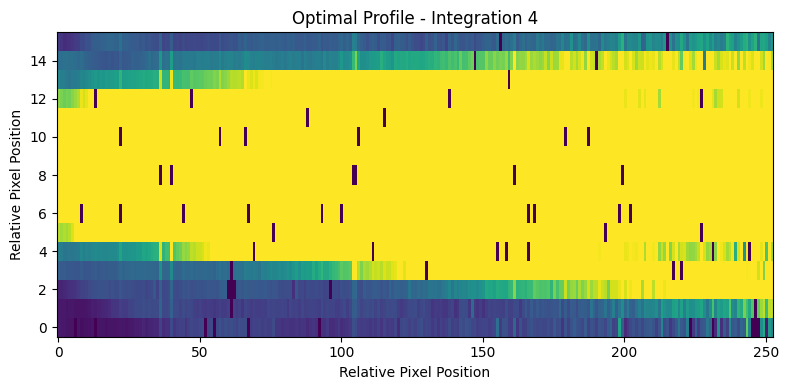

100%|██████████| 312/312 [00:07<00:00, 41.53it/s] 

  Creating figures for optimal spectral extraction



  0%|          | 0/5 [00:00<?, ?it/s]

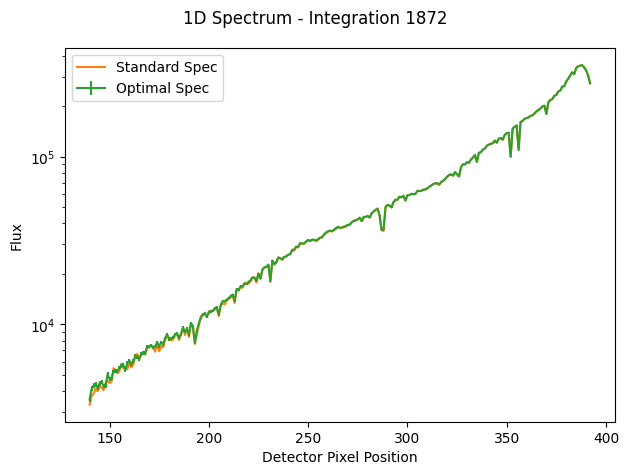

 20%|██        | 1/5 [00:01<00:06,  1.65s/it]

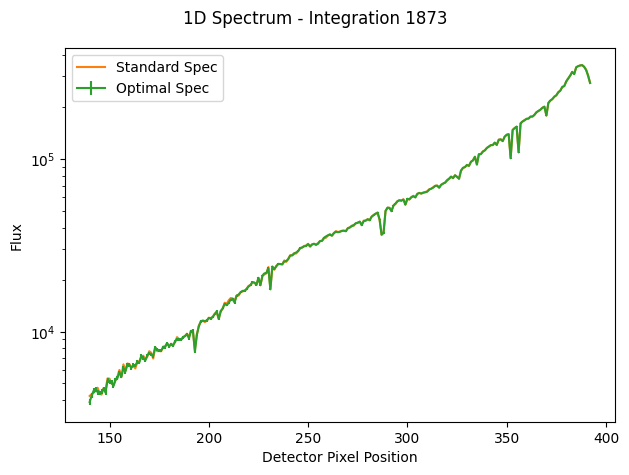

 40%|████      | 2/5 [00:03<00:04,  1.65s/it]

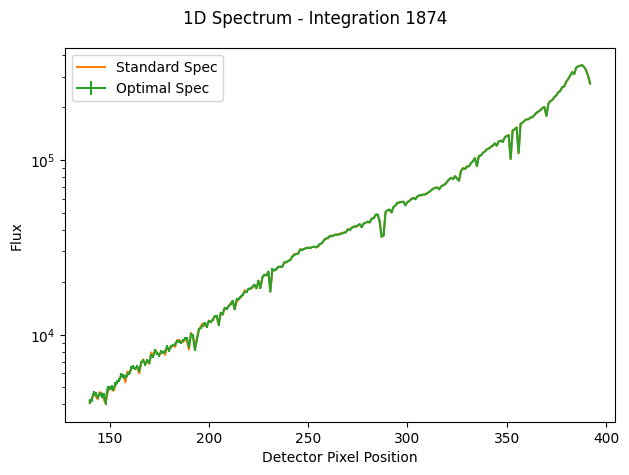

 60%|██████    | 3/5 [00:04<00:03,  1.65s/it]

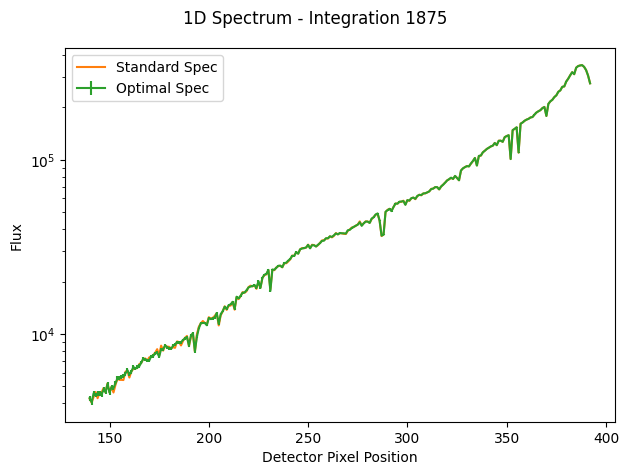

 80%|████████  | 4/5 [00:06<00:01,  1.44s/it]

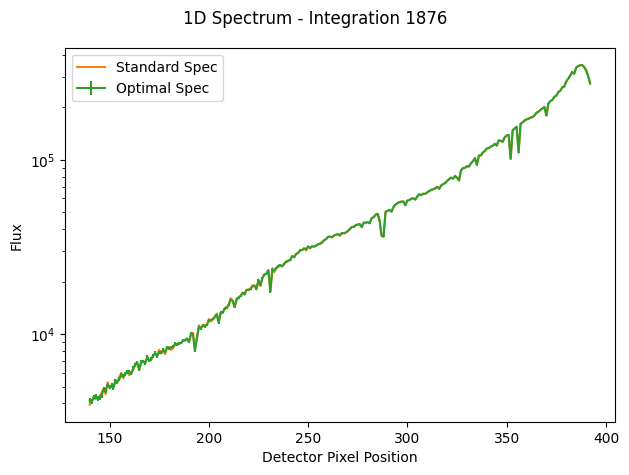

100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


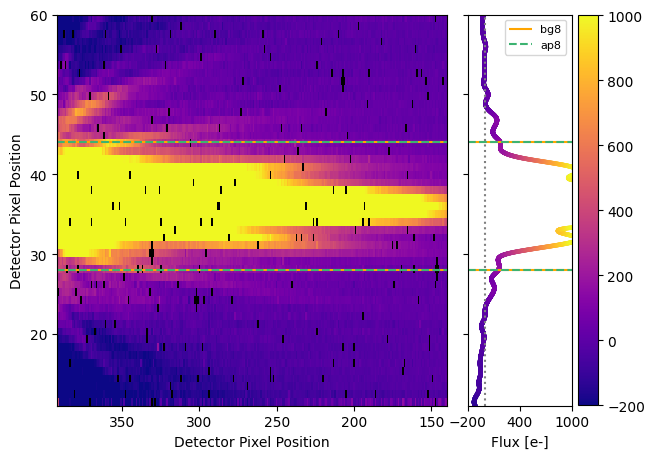

Finished writing to /content/drive/MyDrive/SSW2023/MIRI/Stage3/S3_2023-07-28_miri_run2/ap8_bg8/S3_miri_ap8_bg8_FluxData_seg0002.h5
Starting file 4 of 5
  Masking NaNs/infs in data arrays...
  Locating source position...


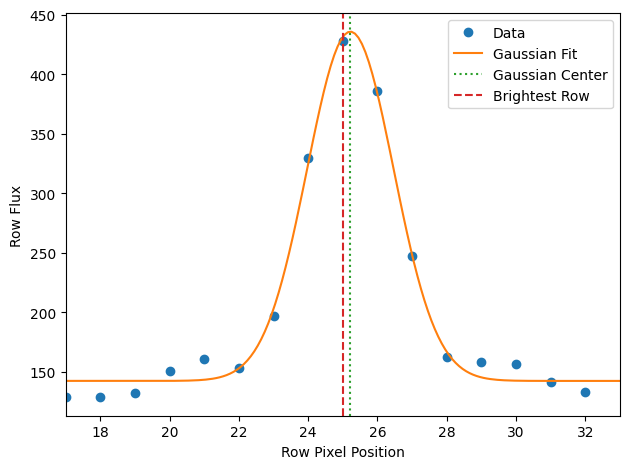

    Source position on detector is row 25.
  Using provided gain=3.1 to convert units to electrons...
  Converting from data numbers per second (DN/s) to electrons...
  Computing clean median frame...


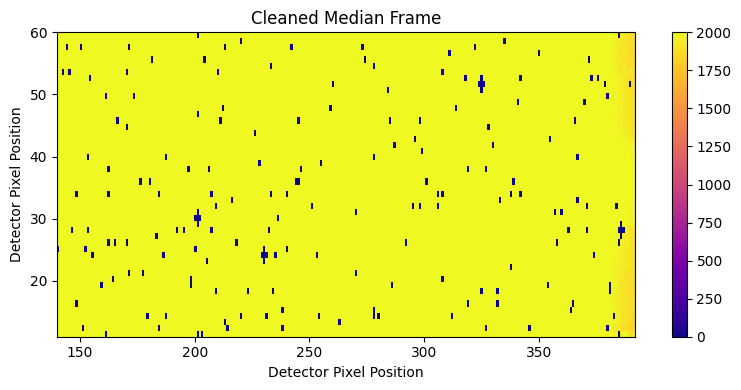

  Performing background outlier rejection...
  Performing CxC background subtraction...


100%|██████████| 312/312 [00:29<00:00, 10.54it/s]


  Creating figures for background subtraction...


  0%|          | 0/5 [00:00<?, ?it/s]

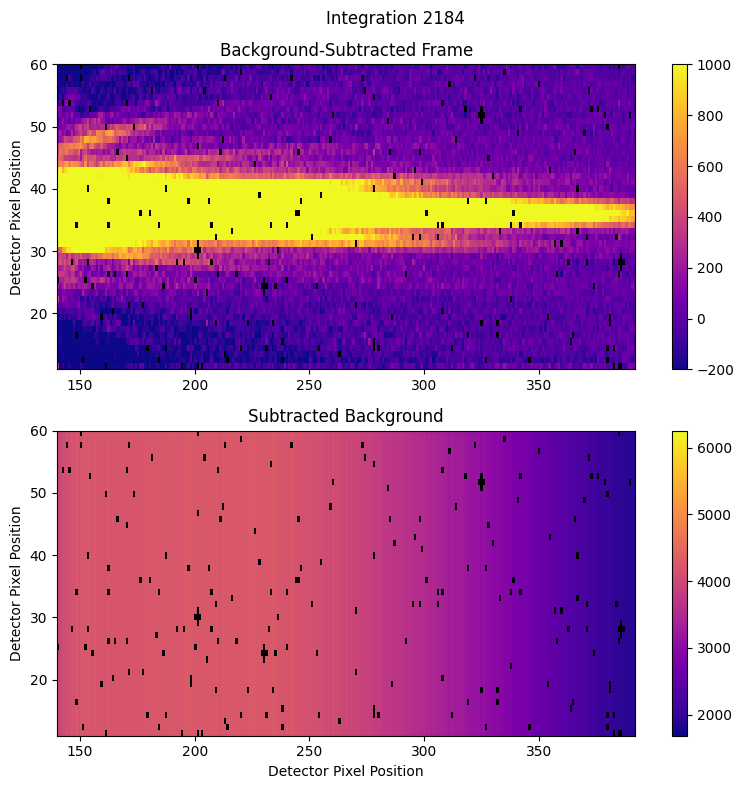

 20%|██        | 1/5 [00:01<00:06,  1.68s/it]

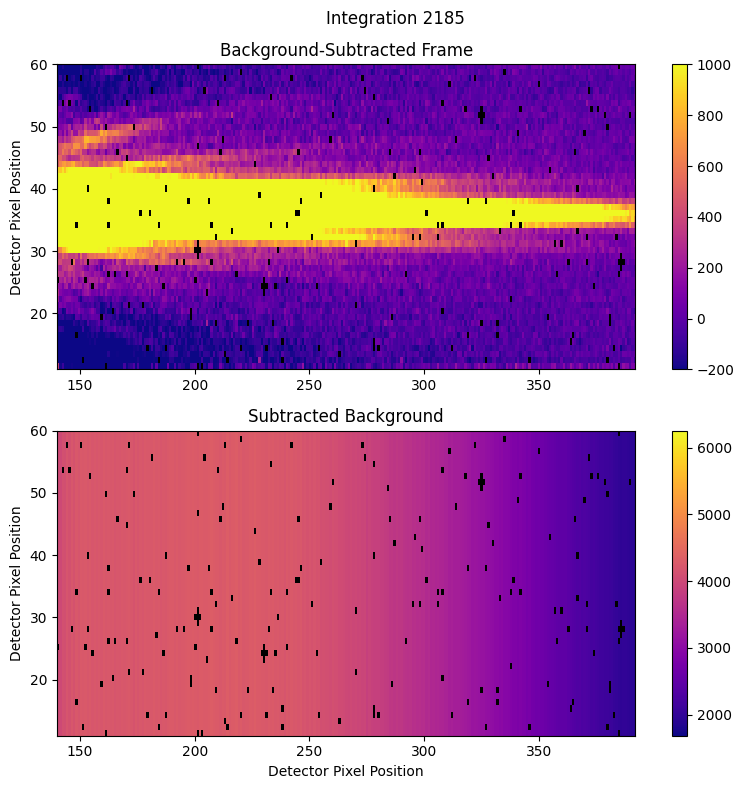

 40%|████      | 2/5 [00:03<00:05,  1.68s/it]

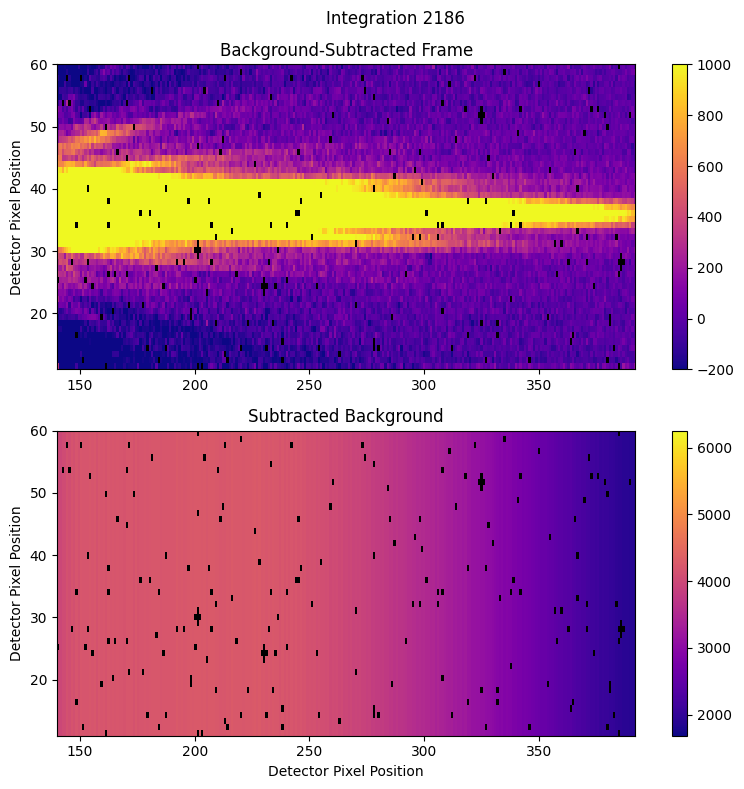

 60%|██████    | 3/5 [00:05<00:03,  1.83s/it]

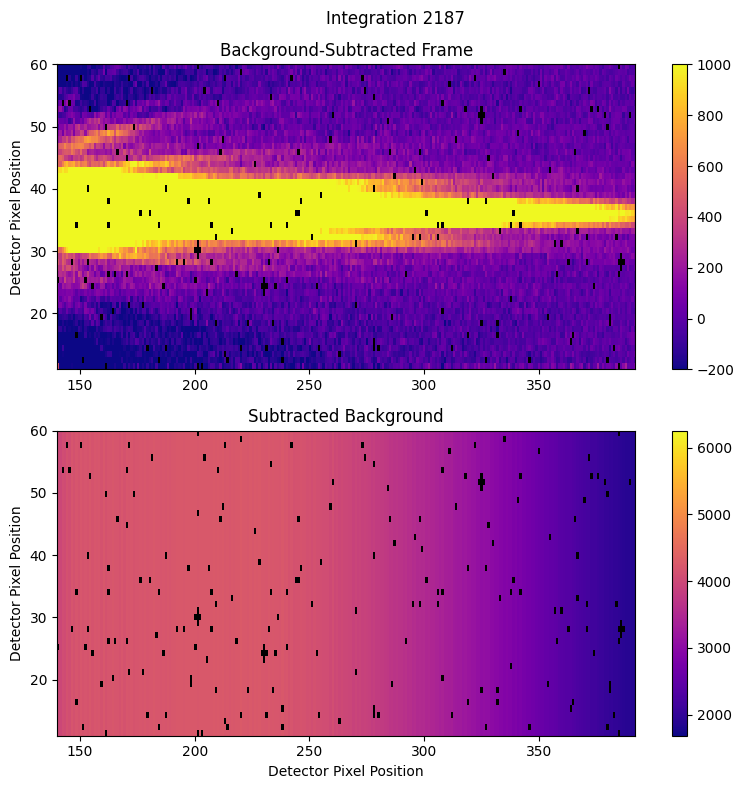

 80%|████████  | 4/5 [00:07<00:01,  1.77s/it]

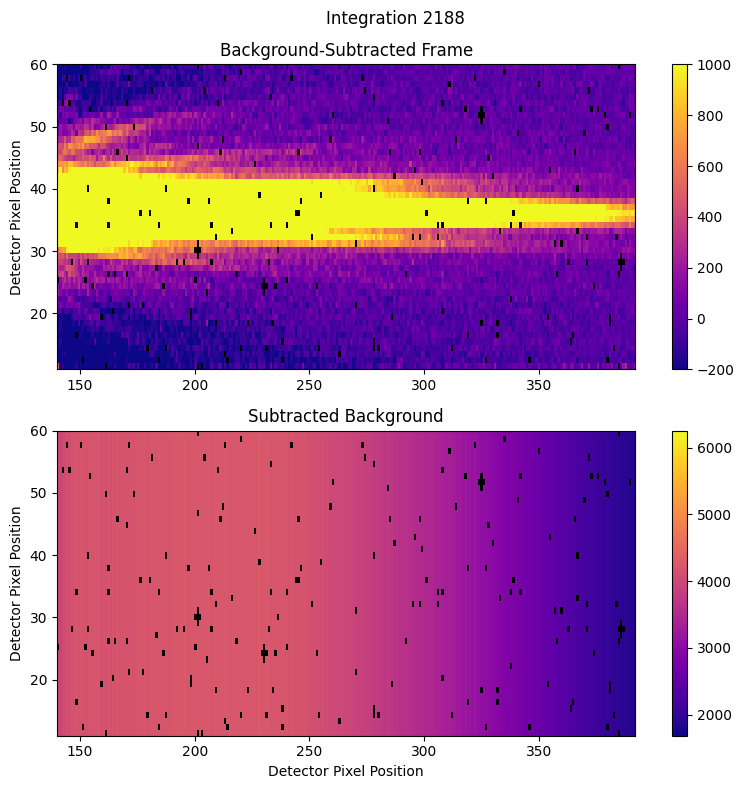

100%|██████████| 5/5 [00:09<00:00,  1.83s/it]

  Recording y position and width for all integrations...



100%|██████████| 312/312 [00:01<00:00, 174.17it/s]


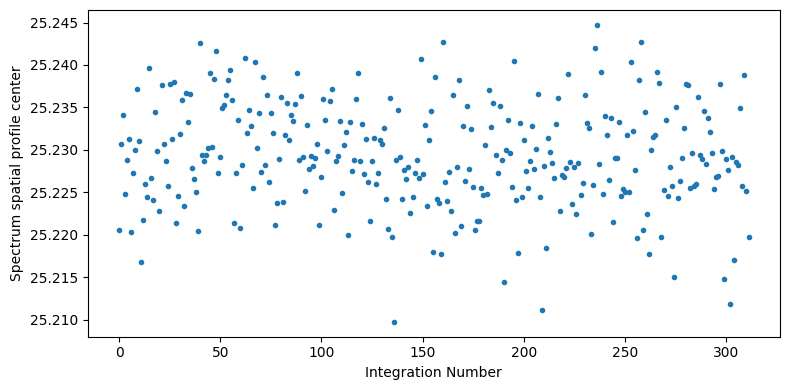

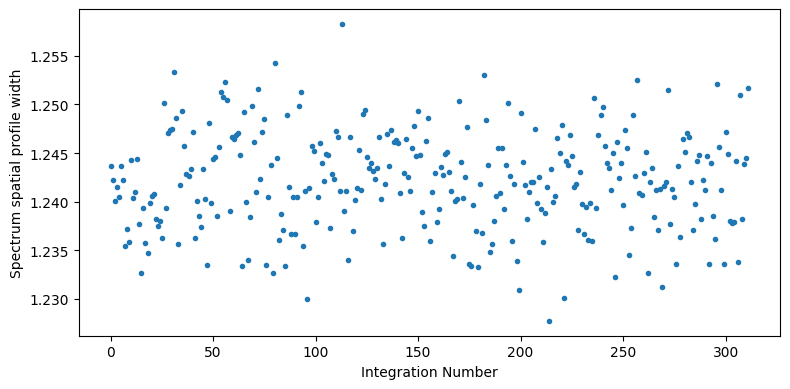

  Extracting aperture region...
  Performing optimal spectral extraction...


  0%|          | 0/312 [00:00<?, ?it/s]

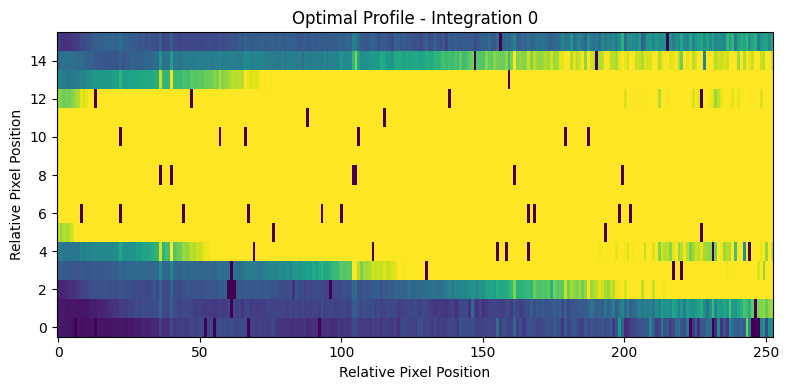

  0%|          | 1/312 [00:01<06:35,  1.27s/it]

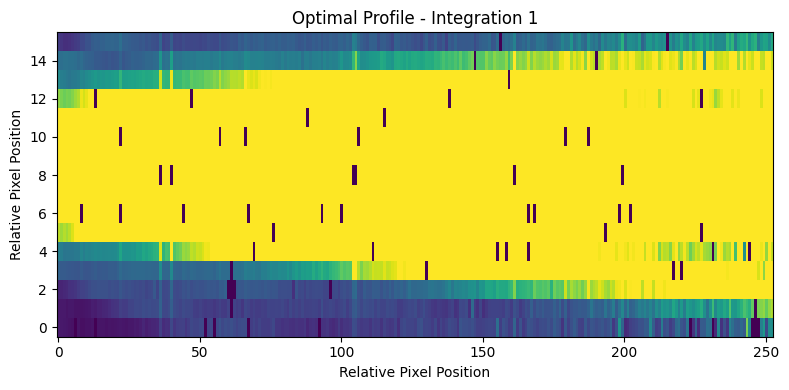

  1%|          | 2/312 [00:02<06:45,  1.31s/it]

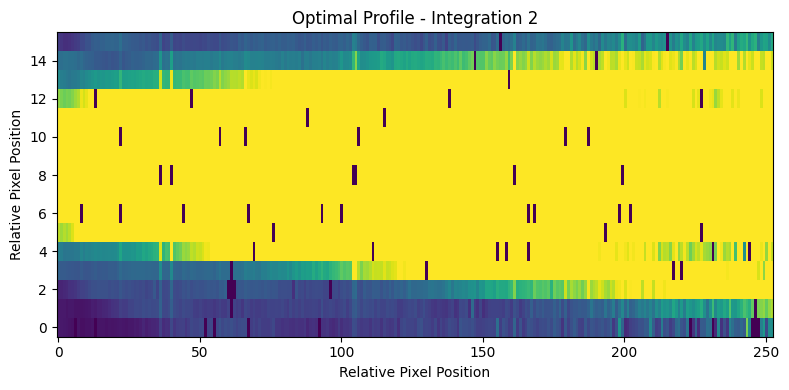

  1%|          | 3/312 [00:03<06:45,  1.31s/it]

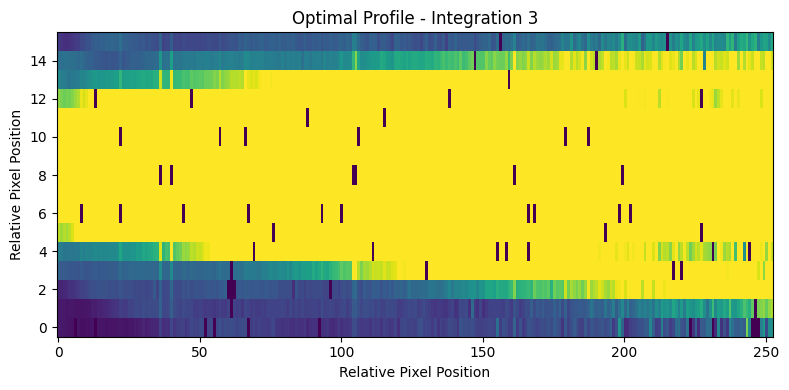

  1%|▏         | 4/312 [00:05<06:35,  1.28s/it]

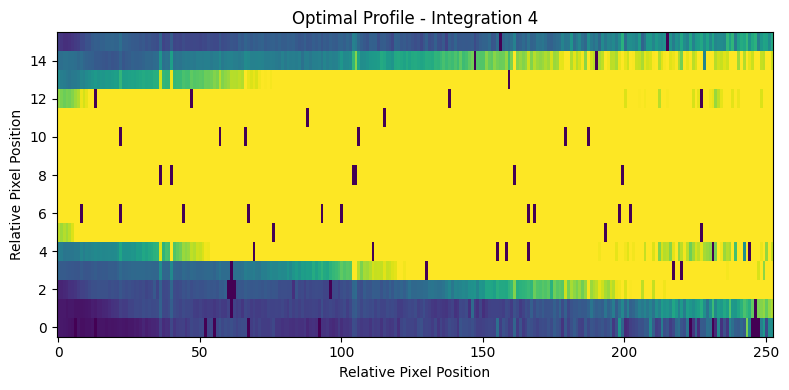

100%|██████████| 312/312 [00:07<00:00, 41.72it/s] 

  Creating figures for optimal spectral extraction



  0%|          | 0/5 [00:00<?, ?it/s]

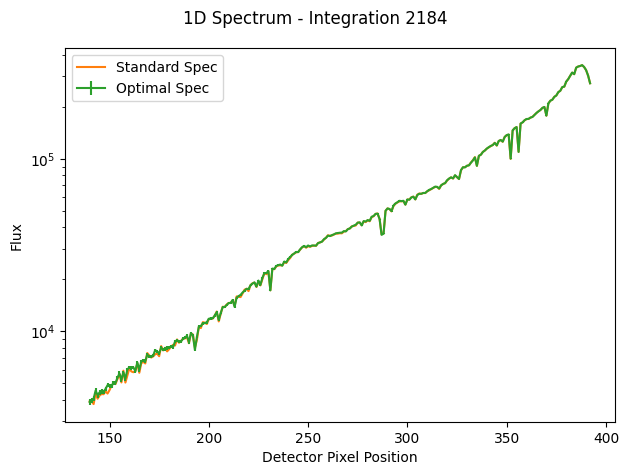

 20%|██        | 1/5 [00:01<00:04,  1.20s/it]

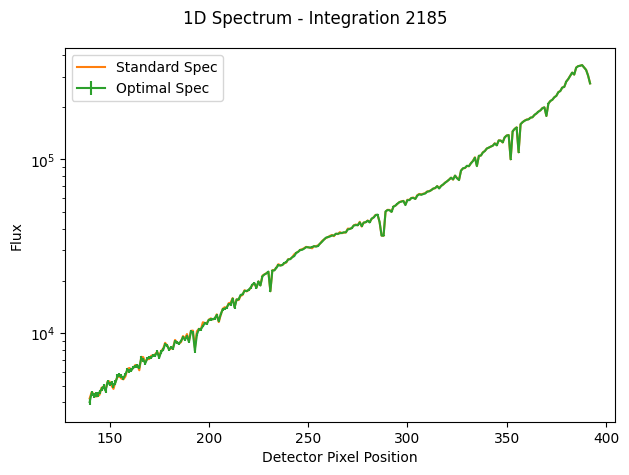

 40%|████      | 2/5 [00:02<00:03,  1.15s/it]

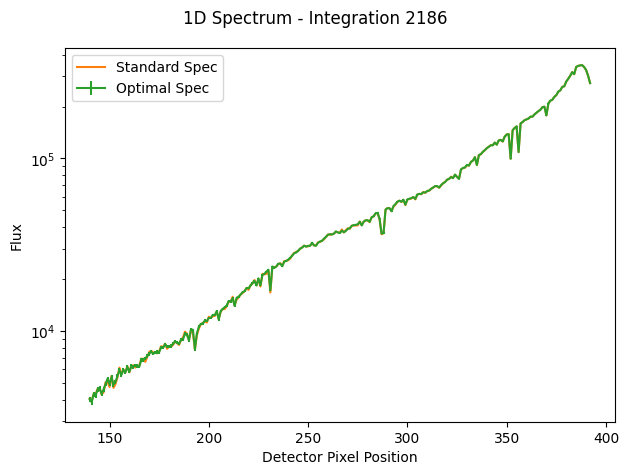

 60%|██████    | 3/5 [00:03<00:02,  1.14s/it]

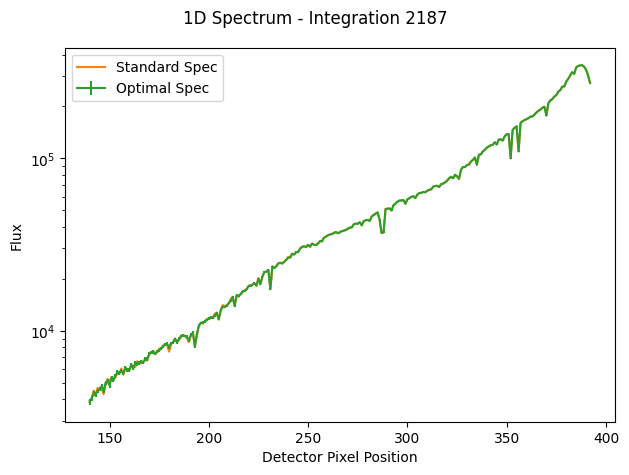

 80%|████████  | 4/5 [00:04<00:01,  1.12s/it]

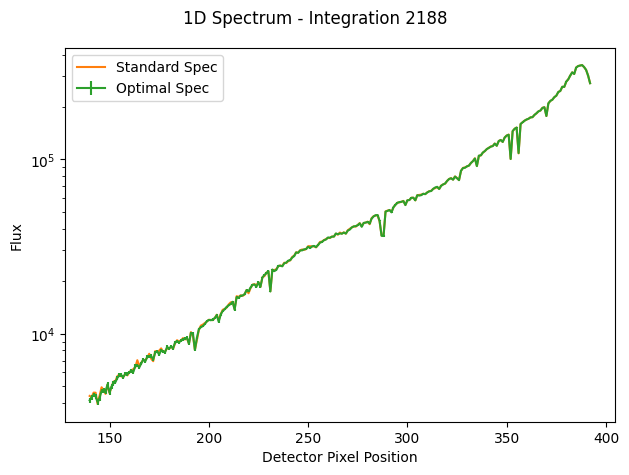

100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


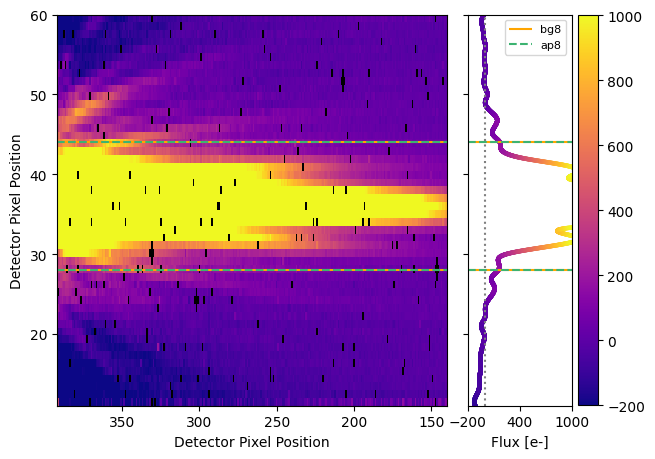

Finished writing to /content/drive/MyDrive/SSW2023/MIRI/Stage3/S3_2023-07-28_miri_run2/ap8_bg8/S3_miri_ap8_bg8_FluxData_seg0003.h5
Starting file 5 of 5
  Masking NaNs/infs in data arrays...
  Locating source position...


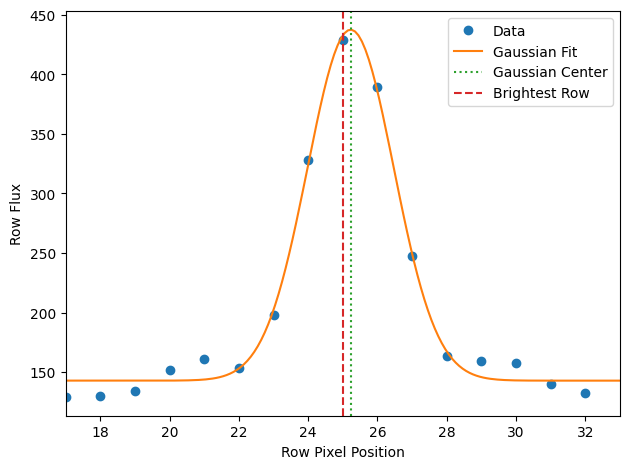

    Source position on detector is row 25.
  Using provided gain=3.1 to convert units to electrons...
  Converting from data numbers per second (DN/s) to electrons...
  Computing clean median frame...


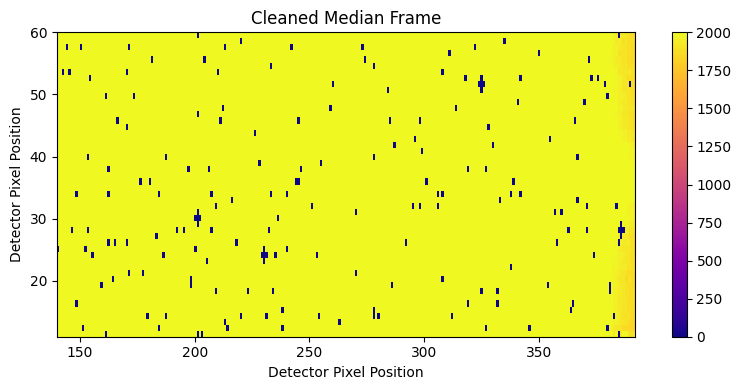

  Performing background outlier rejection...
  Performing CxC background subtraction...


100%|██████████| 312/312 [00:27<00:00, 11.15it/s]


  Creating figures for background subtraction...


  0%|          | 0/5 [00:00<?, ?it/s]

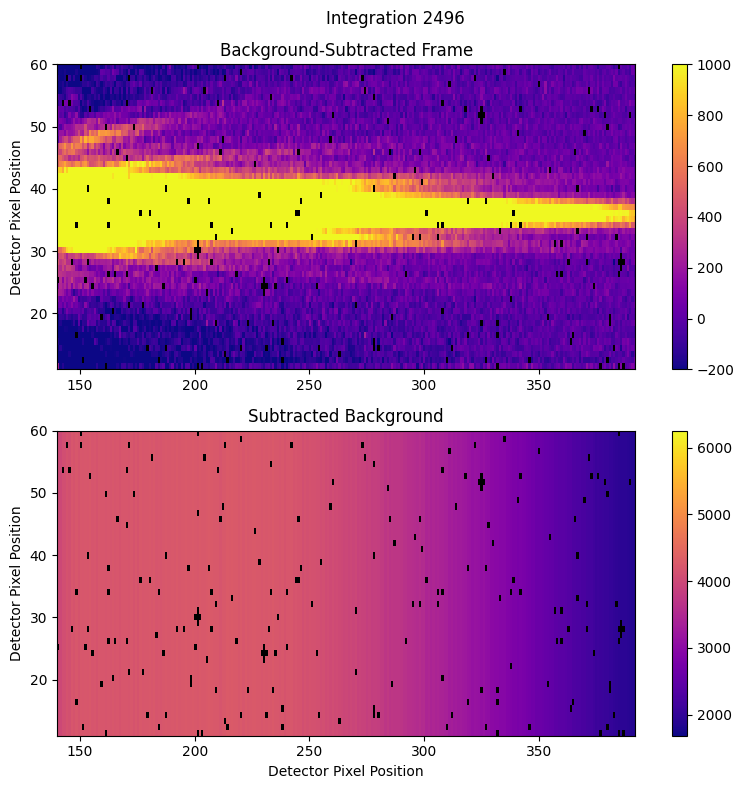

 20%|██        | 1/5 [00:01<00:07,  1.97s/it]

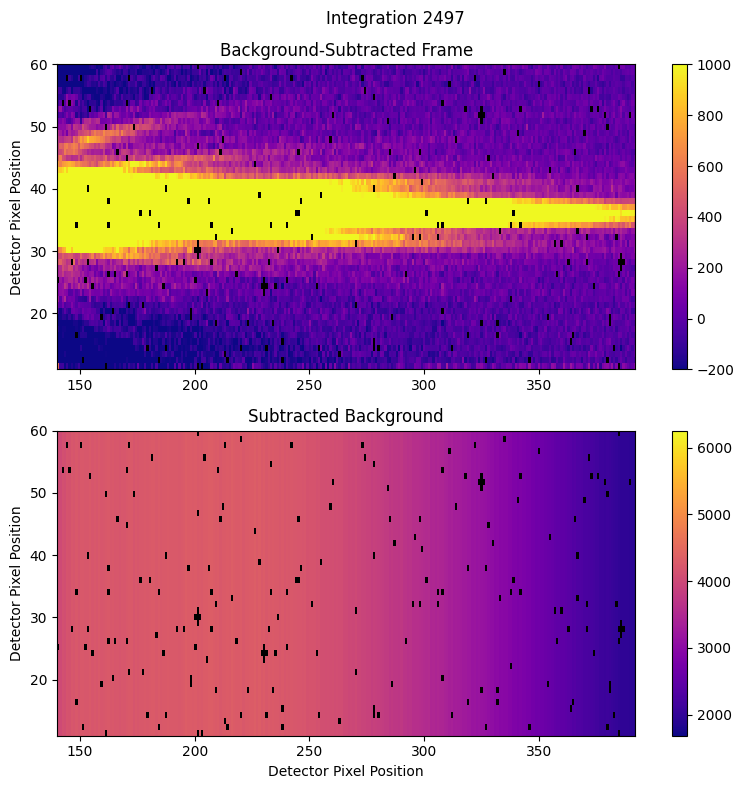

 40%|████      | 2/5 [00:03<00:05,  1.80s/it]

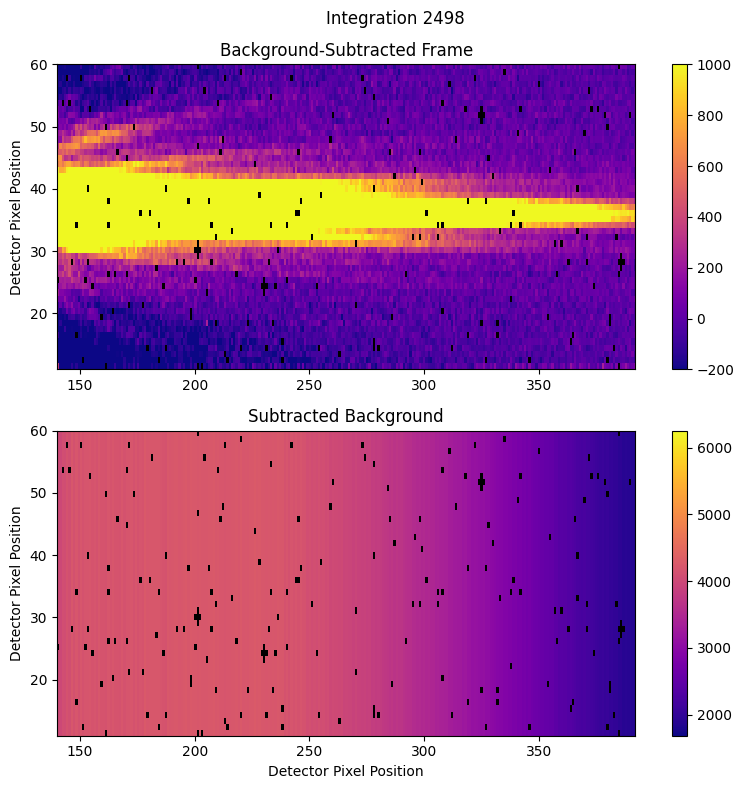

 60%|██████    | 3/5 [00:06<00:04,  2.08s/it]

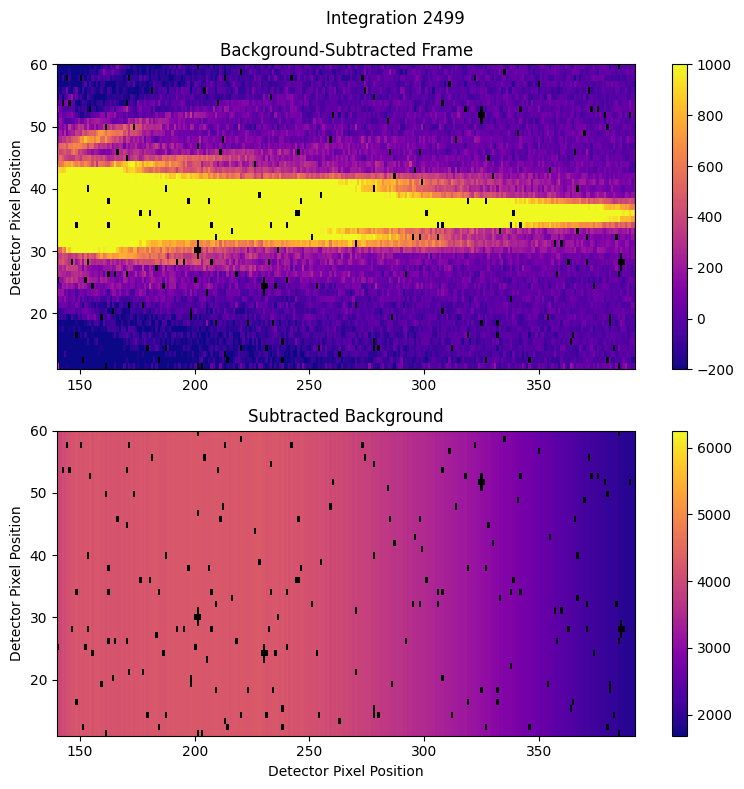

 80%|████████  | 4/5 [00:08<00:02,  2.26s/it]

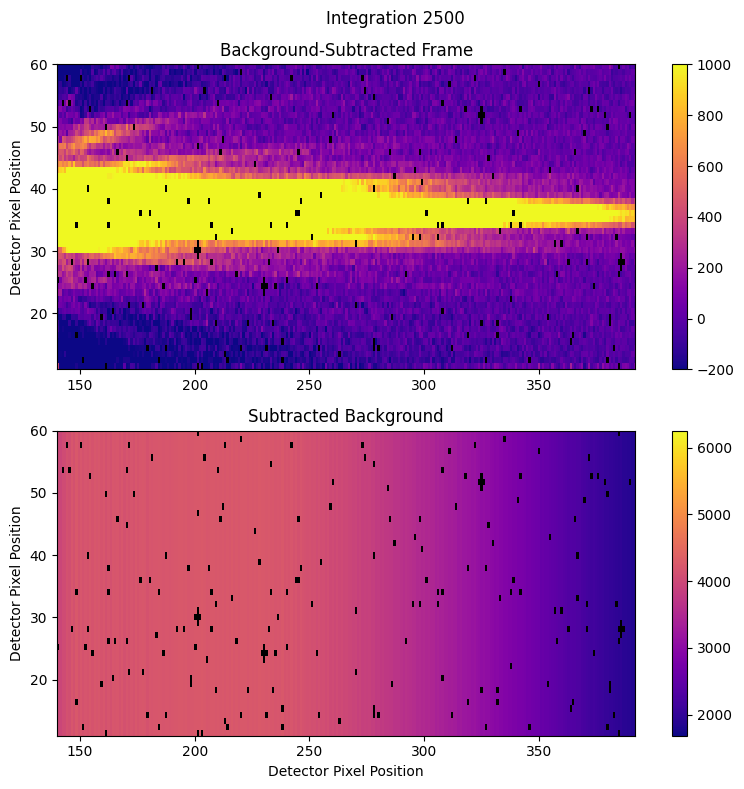

100%|██████████| 5/5 [00:11<00:00,  2.22s/it]

  Recording y position and width for all integrations...



100%|██████████| 312/312 [00:02<00:00, 149.08it/s]


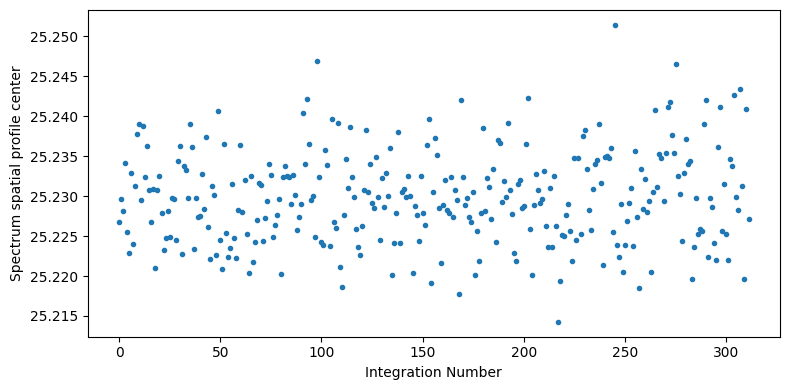

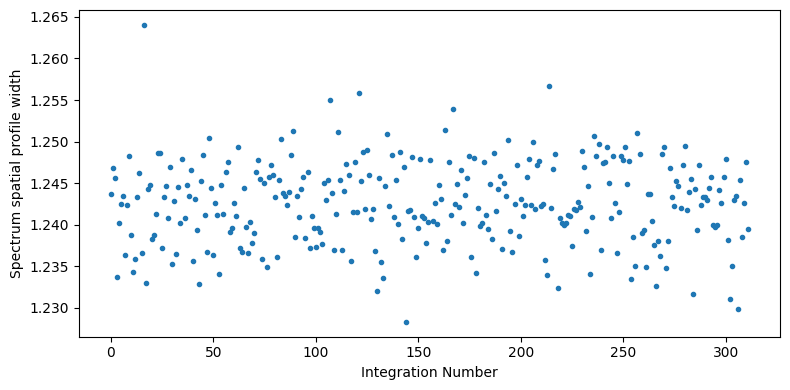

  Extracting aperture region...
  Performing optimal spectral extraction...


  0%|          | 0/312 [00:00<?, ?it/s]

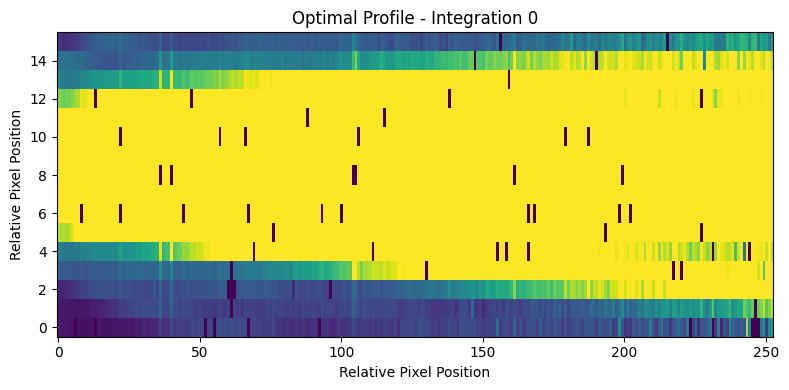

  0%|          | 1/312 [00:00<04:58,  1.04it/s]

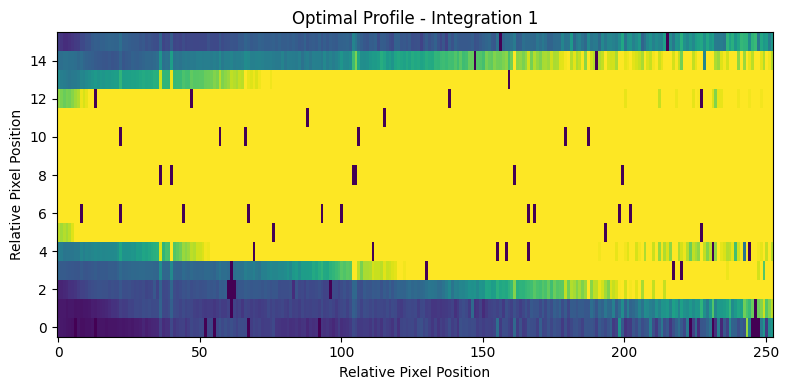

  1%|          | 2/312 [00:01<04:54,  1.05it/s]

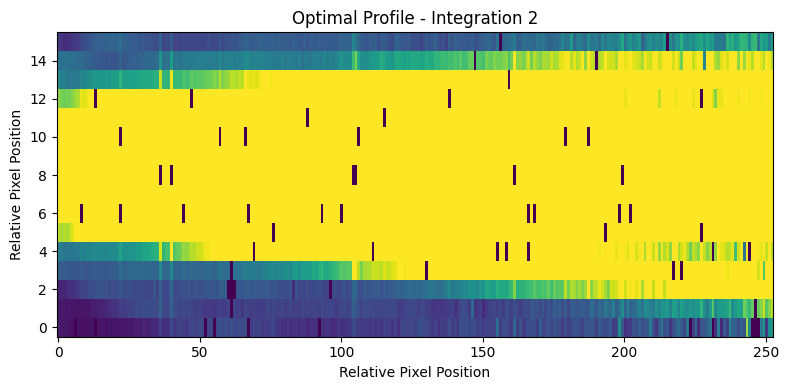

  1%|          | 3/312 [00:02<04:48,  1.07it/s]

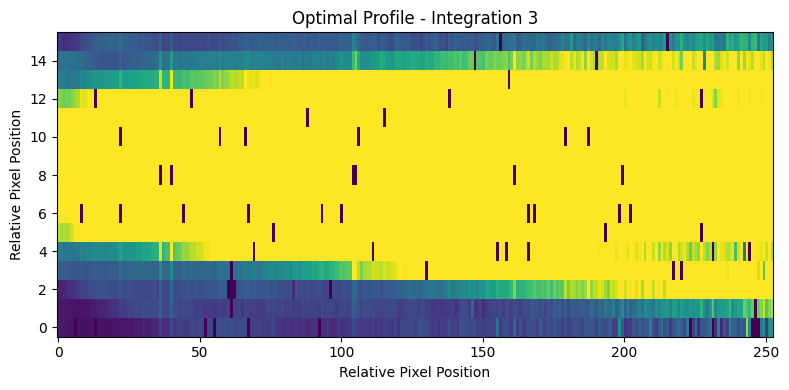

  1%|▏         | 4/312 [00:03<04:43,  1.09it/s]

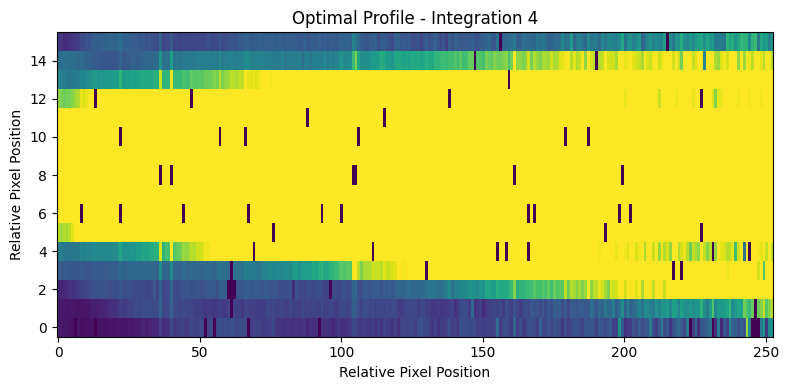

100%|██████████| 312/312 [00:06<00:00, 51.05it/s] 

  Creating figures for optimal spectral extraction



  0%|          | 0/5 [00:00<?, ?it/s]

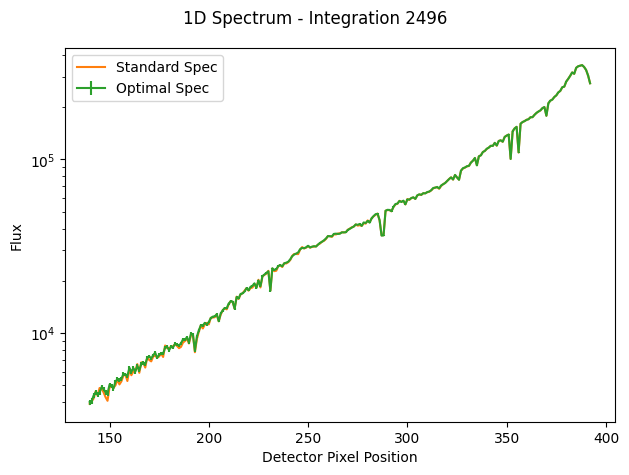

 20%|██        | 1/5 [00:01<00:05,  1.27s/it]

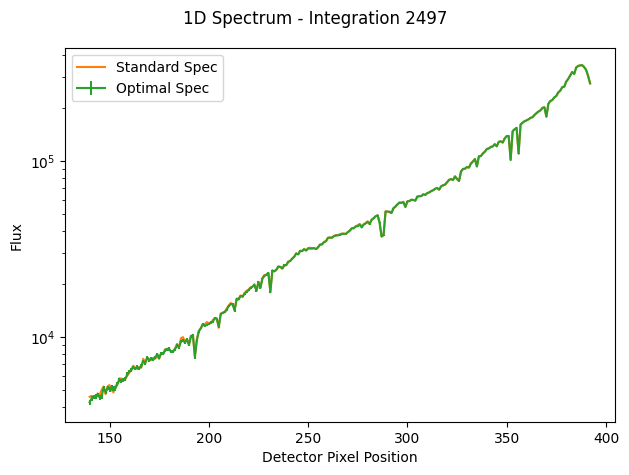

 40%|████      | 2/5 [00:02<00:03,  1.18s/it]

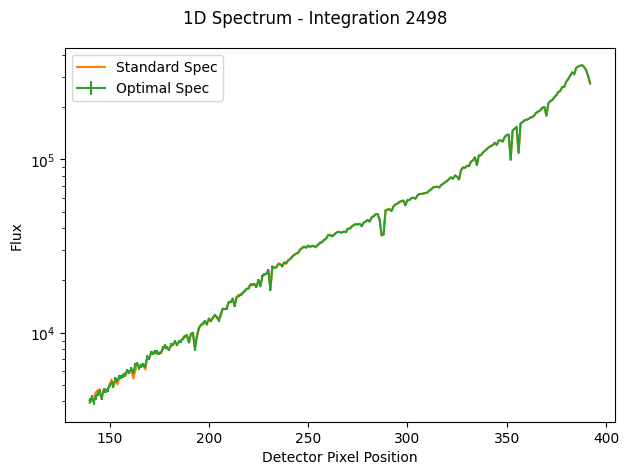

 60%|██████    | 3/5 [00:03<00:02,  1.34s/it]

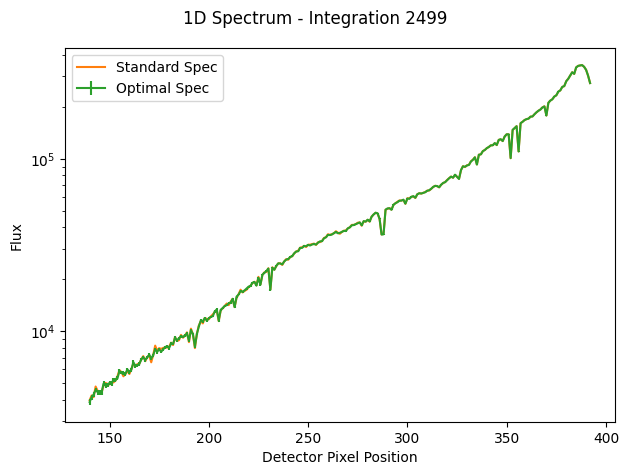

 80%|████████  | 4/5 [00:05<00:01,  1.44s/it]

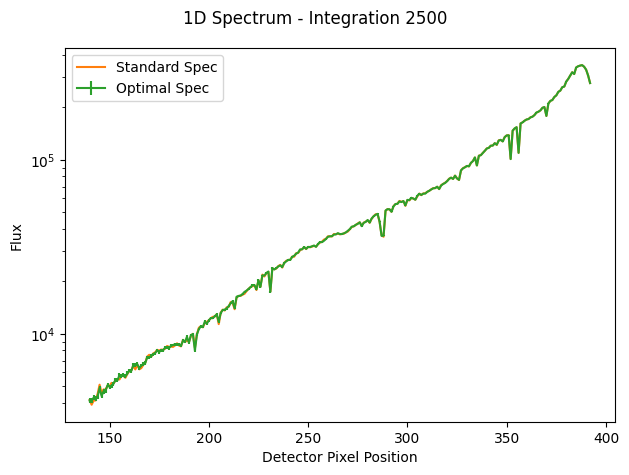

100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


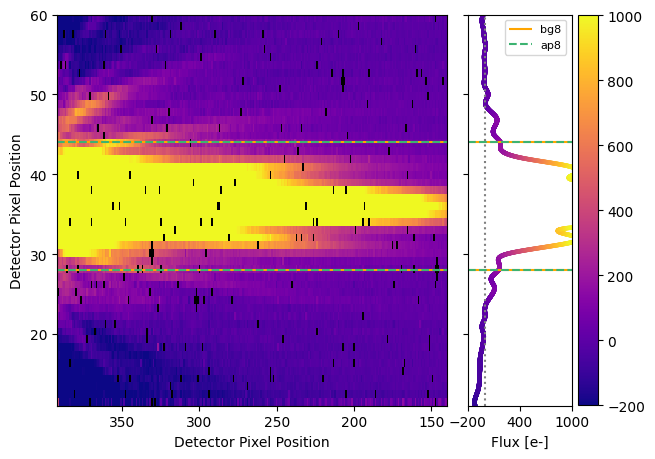

Finished writing to /content/drive/MyDrive/SSW2023/MIRI/Stage3/S3_2023-07-28_miri_run2/ap8_bg8/S3_miri_ap8_bg8_FluxData_seg0004.h5
Finished writing to /content/drive/MyDrive/SSW2023/MIRI/Stage3/S3_2023-07-28_miri_run2/ap8_bg8/S3_miri_ap8_bg8_SpecData.h5
Stage 3 MAD = 10137 ppm
Generating figure


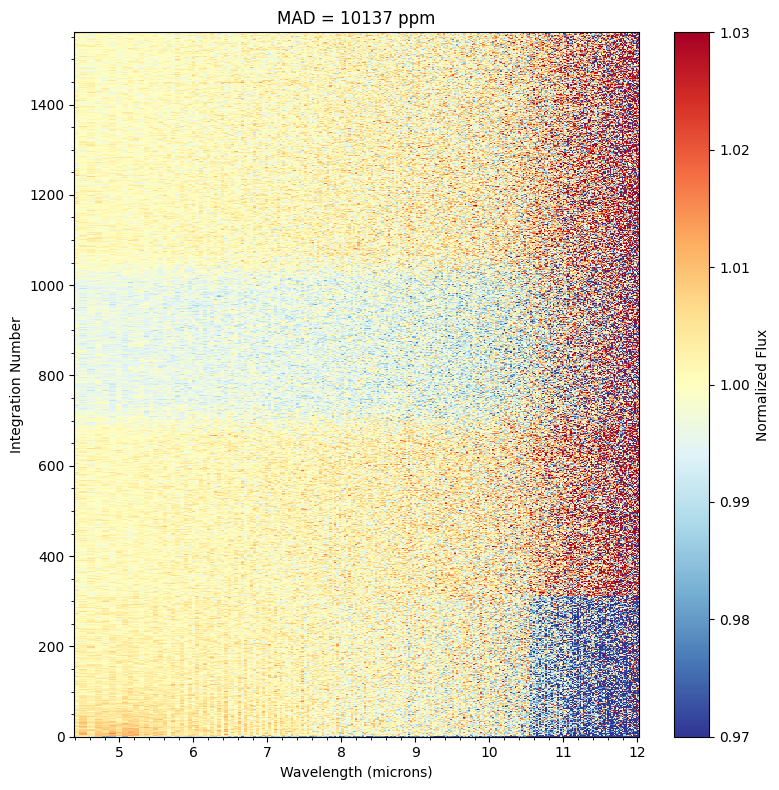

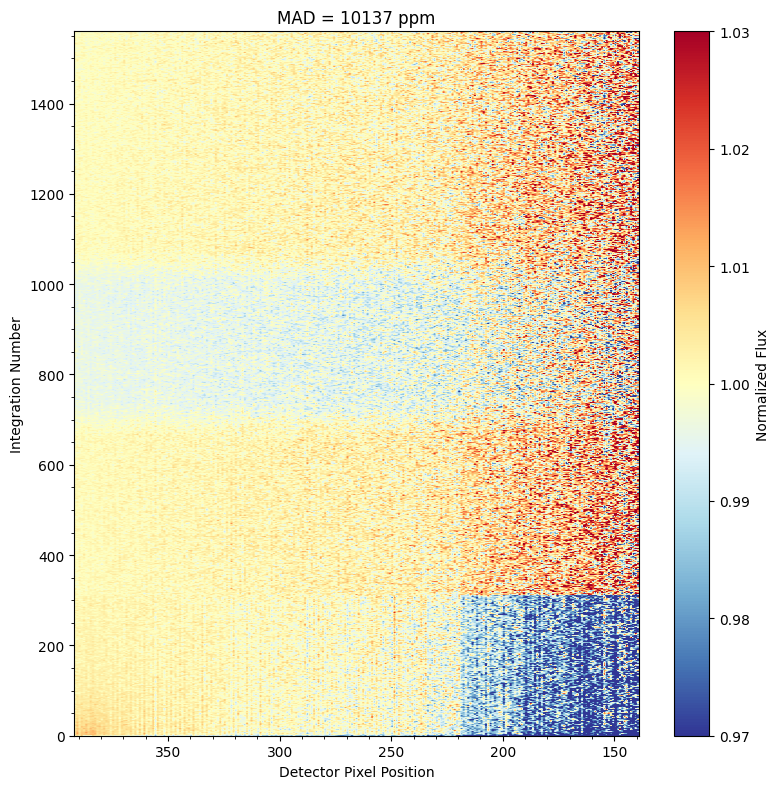

Saving Metadata

Total time (min): 5.77


In [ ]:
s3_spec, s3_meta = eureka.S3_data_reduction.s3_reduce.reduce(eventlabel)

---
# Eureka!'s Stage 4 (white lightcurve)

### Setting the Stage 4 "Eureka! Control File" (ECF)

This determines what will happen during Stage 4

To begin, please first copy below the contents of the ECF template for MIRI/LRS from the `S4_template.ecf` file in the ECF demos folder on [GitHub](https://github.com/kevin218/Eureka/tree/main/demos/JWST).

The most important parameters and their recommended settings are described below, but more context can be found on the [Eureka! documentation website](https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-4).

1.   Let's first produce just a single white lightcurve by setting `nspecchan` to `1`
2.   Since we're only computing the white lightcurve, set `compute_white` to `False` as this feature is meant for cases where `nspecchan` is greater than `1`.
3.   Let's set the `wave_min` and `wave_max` to the approximate minimum and maximum usable wavelengths from MIRI/LRS. Normally we can use the full 5--12 micron wavelength range, but some unusual systematics affected the >10.5 micron region, so set `wave_min` to `5.0` and `wave_max` to `10.5`.
4.   Set `recordDrift` and `correctDrift` to `False` since there are too few spectral lines in the MIRI wavelength range to reliably measure drift/jitter in the dispersion direction. The other parameters in that chunk of inputs can then be safely ignored as they're only used if `recordDrift` or `correctDrift` are `True`.
5.   Remove outliers along the time axis (e.g. cosmic rays) by setting `clip_binned` to `True` (basically always helpful). `clip_unbinned` is typically not helpful and should be set to `False`.


To sigma-clip outliers, we need to have a reference time-series against which we are comparing our observations. If we just took the whole time-series and sigma clipped compared to the median level of the observations, we may well sigma-clip the entire transit signal in cases where there is a strong transit. Instead, we use a [box-car](https://en.wikipedia.org/wiki/Boxcar_function) filter which acts as a [high-pass filter](https://en.wikipedia.org/wiki/High-pass_filter); this removes any low-frequency signals (e.g. transit ingress/egress, phase variations, linear trends in time) and leaves behind high-frequency noise (cosmic rays, HGA moves, etc.). The most important parameters that control this box-car clipping are `sigma` and `box_width`, but `boundary` and `fill_value` are also relevant parameters.

6.   Set `sigma` to a value low enough to clip any obviously errant points while ensuring you are not clipping an excessive number of points and not clipping the transit or eclipse's ingress/egress. For these particular data, something around `4` should do, but this is not a strict rule and will change for each different dataset. The focus here is to remove obviously errant points and not to clip a bunch of points.
7.   Set `box_width` to a value small enough to not sigma-clip the transit or eclipse's ingress/egress, while also not setting it so small that the smoothed copy of the signal is excessively noisy. For these particular data, something around `20` should do, but again this is not a strict rule and will change for each different dataset.
8.   Set `boundary` to `fill` as this typically results in reasonable behaviour at the start and end of the observations.
9.   Set `fill_value` to `mask` in order to mask the clipped outliers without replacement. This ensures you remove bad values without requiring you to replace the masked values with a guess as to the value the point should have (a potentially dangerous endeavour).


Finally, there are some plotting/logging controls you should adjust:

10.  Set `compute_ld` to `False`. Since we're working on an eclipse observation, there is no need to compute theoretical limb-darkening coefficients for the star. The other inputs related to computing limb-darkening coefficients can then safely be ignored.
11.  Set `isplots_S4` to `3` to get some useful diagnostic figures (increase this to 5 if you need more plots to investigate problems).
12.  Set `hide_plots` to `False` so that the figures pop up in this notebook as they're made (set to `True` if you're running the code in the terminal instead of a notebook, otherwise you'll have a lot of windows popping up).
13.  Set `verbose` to `True` so you get lots of useful information printed out.
14.  Set `topdir` to the same value as you used in Stage 3.
15.  Set `inputdir` to `Stage3`. If you end up running multiple version of Eureka!'s Stage 3, you can select the exact one you want as an input to Stage 4 by specifying the folder name in more detail (e.g. `Stage3/S3_2023-07-24_miri_run1`).
16.  Set `outputdir` to `Stage4_white` so that we can distinguish between this white lightcurve from the spectroscopic lightcurves we'll compute later

In [ ]:
s4_ecf_contents = f"""
# Eureka! Control File for Stage 4: Generate Lightcurves

# Stage 4 Documentation: https://eurekadocs.readthedocs.io/en/latest/ecf.html#stage-4

# Number of spectroscopic channels spread evenly over given wavelength range
nspecchan       1           # Number of spectroscopic channels spread evenly over given wavelength range. Set to None to leave the spectrum unbinned.
compute_white   False        # Also compute the white-light lightcurve
wave_min        5.0         # Minimum wavelength. Set to None to use the shortest extracted wavelength from Stage 3.
wave_max        10.5         # Maximum wavelength. Set to None to use the longest extracted wavelength from Stage 3.
allapers        False       # Run S4 on all of the apertures considered in S3? Otherwise will use newest output in the inputdir

# Mannualy mask pixel columns by index number
# mask_columns  []

# Parameters for drift correction of 1D spectra
recordDrift     False    # Set True to record drift/jitter in 1D spectra (always recorded if correctDrift is True)
correctDrift    False   # Set True to correct drift/jitter in 1D spectra (not recommended for simulated data)
drift_preclip   0       # Ignore first drift_preclip points of spectrum
drift_postclip  100     # Ignore last drift_postclip points of spectrum, None = no clipping
drift_range     11      # Trim spectra by +/-X pixels to compute valid region of cross correlation
drift_hw        5       # Half-width in pixels used when fitting Gaussian, must be smaller than drift_range
drift_iref      -1      # Index of reference spectrum used for cross correlation, -1 = last spectrum
sub_mean        True    # Set True to subtract spectrum mean during cross correlation
sub_continuum   True    # Set True to subtract the continuum from the spectra using a highpass filter
highpassWidth   10      # The integer width of the highpass filter when subtracting the continuum

# Parameters for sigma clipping
clip_unbinned   False   # Whether or not sigma clipping should be performed on the unbinned 1D time series
clip_binned     True    # Whether or not sigma clipping should be performed on the binned 1D time series
sigma           4      # The number of sigmas a point must be from the rolling median to be considered an outlier
box_width       20      # The width of the box-car filter (used to calculated the rolling median) in units of number of data points
maxiters        5       # The number of iterations of sigma clipping that should be performed.
boundary        'fill'  # Use 'fill' to extend the boundary values by the median of all data points (recommended), 'wrap' to use a periodic boundary, or 'extend' to use the first/last data points
fill_value      mask    # Either the string 'mask' to mask the outlier values (recommended), 'boxcar' to replace data with the mean from the box-car filter, or a constant float-type fill value.

# Limb-darkening parameters needed to compute exotic-ld
compute_ld      False
inst_filter     prism   # Filter of JWST/HST instrument, supported list see https://exotic-ld.readthedocs.io/en/latest/views/supported_instruments.html
metallicity     0.1     # Metallicity of the star
teff            6000    # Effective temperature of the star in K
logg            4.0     # Surface gravity in log g
exotic_ld_direc /home/User/exotic-ld_data/ # Directory for ancillary files for exotic-ld, download from: https://zenodo.org/record/6344946
exotic_ld_grid  3D      # 1D or 3D model grid
exotic_ld_file  /home/User/exotic-ld_data/Custom_throughput_file.csv # Custom throughput file, for examples see Eureka/demos/JWST/Custom_throughput_files

# Diagnostics
isplots_S4      3       # Generate few (1), some (3), or many (5) figures (Options: 1 - 5)
vmin            0.97    # Sets the vmin of the color bar for Figure 4101.
vmax            1.03    # Sets the vmax of the color bar for Figure 4101.
time_axis       'y'     # Determines whether the time axis in Figure 4101 is along the y-axis ('y') or the x-axis ('x')
hide_plots      False   # If True, plots will automatically be closed rather than popping up
verbose         True    # If True, more details will be printed about steps

# Project directory
topdir          /content/drive/MyDrive/SSW2023/MIRI

# Directories relative to topdir
inputdir        Stage3    # The folder containing the outputs from Eureka!'s S3 or JWST's S3 pipeline (will be overwritten if calling S3 and S4 sequentially)
outputdir       Stage4_
# Fill this text block with the contents of the S4 template from https://github.com/kevin218/Eureka/tree/main/demos/JWST
# and then adjust the values as described above

"""

# This will save the ECF as a file that the next cell can read-in
with open(f'S4_{eventlabel}.ecf', 'w') as f:
    f.write(s4_ecf_contents)

### Running Eureka!'s Stage 4

The following cell will run Eureka!'s Stage 4 using the settings you defined above. Note that your ECF will be copied to your output folder, making it easy to remember how you produced those outputs hours, days, or years after you reduced the data.

This stage of Eureka! will take &lt;1 minute to complete on Google Colab for these particular data.

"/content/drive/MyDrive/SSW2023/MIRI/Stage3/"
Using the metadata file: 
/content/drive/MyDrive/SSW2023/MIRI/Stage3/S3_2023-07-28_miri_run2/ap8_bg8/S3_miri_ap8_bg8_Meta_Save.dat
and will consider aperture ranges listed there. If this metadata file is not a part
of the run you intended, please provide a more precise folder for the metadata file.

Starting Stage 4: Generate Light Curves

Input directory: /content/drive/MyDrive/SSW2023/MIRI/Stage3/S3_2023-07-28_miri_run2/ap8_bg8/
Output directory: /content/drive/MyDrive/SSW2023/MIRI/Stage4_/S4_2023-07-28_miri_run2/ap8_bg8/
Copying S4 control file
Loading S3 save file:
/content/drive/MyDrive/SSW2023/MIRI/Stage3/S3_2023-07-28_miri_run2/ap8_bg8/S3_miri_ap8_bg8_SpecData.h5
Finished loading parameters from /content/drive/MyDrive/SSW2023/MIRI/Stage3/S3_2023-07-28_miri_run2/ap8_bg8/S3_miri_ap8_bg8_SpecData.h5
Stage 4 MAD = 5200.09 ppm


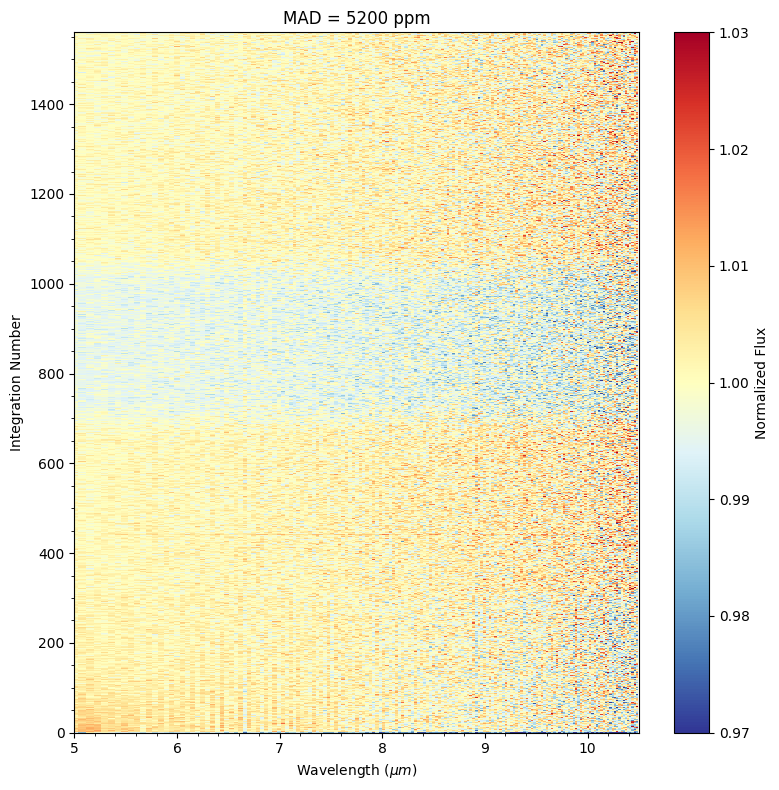

Generating light curves
  Bandpass 0 = 5.000 - 10.500
  Sigma clipped 5 outliers in time series
    MAD = 341 ppm


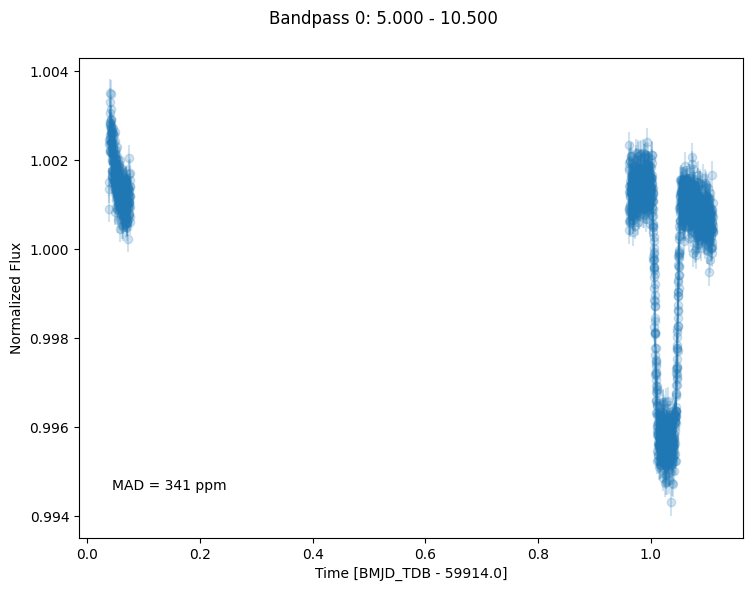

Saving results...
Finished writing to /content/drive/MyDrive/SSW2023/MIRI/Stage4_/S4_2023-07-28_miri_run2/ap8_bg8/S4_miri_ap8_bg8_SpecData.h5
Finished writing to /content/drive/MyDrive/SSW2023/MIRI/Stage4_/S4_2023-07-28_miri_run2/ap8_bg8/S4_miri_ap8_bg8_LCData.h5

Total time (min): 0.12


In [ ]:
s4_spec, s4_lc, s4_meta = eureka.S4_generate_lightcurves.s4_genLC.genlc(eventlabel)

---
# Eureka!'s Stage 4 (spectroscopic lightcurves)

### Setting the Stage 4 "Eureka! Control File" (ECF)

Now that you have successfully computed a white lightcurve, let's compute spectroscopic lightcurves. To do this, copy-paste your Stage 4 ECF contents from above and then:

1.   Change `nspecchan` to `11` to get 11 spectral channels across the specified 5–10.5 micron wavelength range, each of which will have a width of 0.5 microns.
2.   Change `compute_white` to `True` (not critical now, but may be useful to you in Workshop #2 or during your group project).
3.   Change `outputdir` to `Stage4` (to keep it separate from the white lightcurve outputs in the Stage4_white folder)

That's all we need to change to get spectroscopic lightcurves!

In [ ]:
s4_ecf_contents = f"""

# You can copy-paste your Stage 4 ECF contents from above here, and then just adjust nspecchan, compute_white, and outputdir as described above

"""

# This will save the ECF as a file that the next cell can read-in.
# This will overwrite your previous Stage 4 ECF, but you'll still have all the
# information here in this notebook as well as a copied version of your ECF in
# your output folder.
with open(f'S4_{eventlabel}.ecf', 'w') as f:
    f.write(s4_ecf_contents)

### Running Eureka!'s Stage 4

The following cell will run Eureka!'s Stage 4 using the settings you defined above. Note that your ECF will be copied to your output folder, making it easy to remember how you produced those outputs hours, days, or years after you reduced the data.

This stage of Eureka! will take &lt;1 minute to complete on Google Colab for these particular data.

In [ ]:
s4_spec, s4_lc, s4_meta = eureka.S4_generate_lightcurves.s4_genLC.genlc(eventlabel)

---
# Bonus: Getting the "best" reduction

Seeking the "best" reduction is where we venture into the art of data reduction, with various parameters sometimes having appreciable impacts on the precision we can get from our observations and (frighteningly) sometimes significantly impacting our final planetary spectra. At all times, think critically about the settings you are using and the potential for unintended consequences.

If you want to try to get even better results, focus on trying different values in Stage 3 for:

**Most impactful:**
*   `spec_hw` (with a larger aperture you capture more of the star's light but also capture more noisy background light - there is a trade-off here which will likely change for every different target you observe)
*   `bg_hw` (with a smaller value you have more background pixels but also more stellar contamination - there is a trade-off here which will likely change for every different target you observe)

**Intermediate impact:**
*   `p3thresh` (the best value will likely change depending on the value you use for `bg_hw`)
*   `p7thresh` (try larger/smaller values)
*   `window_len` (try values roughly in the range of `2`–`11` - larger values may help to smooth over noise in your profile, but if the value is too large it can result in bad extraction profiles and potentially biased results)
*   `median_thresh` (try larger/smaller values - note that this is only used if `fittype` is set to `meddata` and `window_len` is larger than `1`).

**Uncertain impact:**
*   `bg_thresh` (you likely won't see large changes, but might slightly improve the overall scatter)
*   `fittype` (try `smooth`)

<br/>

Typically the "best" value for each parameter is independent of the values of other parameters, but sometimes there are interactions (e.g. a smaller `bg_hw` may require smaller `p3thresh`). The Stage 4 MAD (Median Absolute Deviation) value is an approximate tool you can use to determine how much your reduction has improved (typically the lower the value, the lower the noise in your lightcurve, and the "better" the reduction). A better indication of an improved reduction is the RMS of the residuals from your Stage 5 fit (discussed in the Hands-On Session #2) since the Stage 4 MAD doesn't account for noise that can be decorrelated when fitting, but depending on your dataset it can be prohibitively time-intensive to continuously run all reduction options through Stage 5.

Again though, remain critical and vigilant at all times when optimizing your reduction. For example, you'll be able to decrease your MAD value by setting your Stage 4 `sigma` value to `0.01`, but you're going to end up discarding nearly all of your data which you definitely don't want to do. A less obvious danger might be setting Stage 3's `bg_hw` parameter to too small a value, resulting in self-subtraction and potentially biased transit or eclipse depths.